# Neumann Boundary Condition

In [1]:
%load_ext autoreload
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'NBC'
omega = 10
oce_val = 0
gamma =3e-8

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

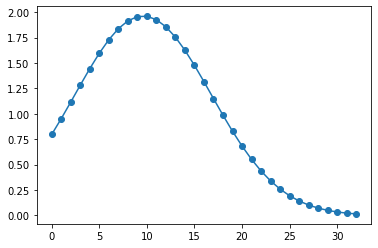

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.show()

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 1.0#cos(0.0)*3*pi
u0R = 0.1 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

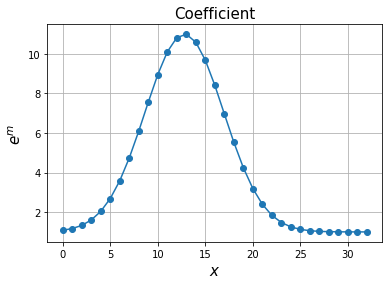

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

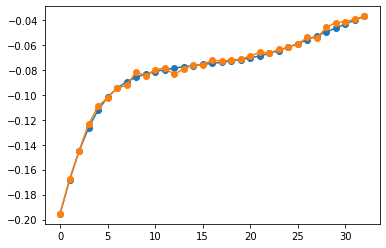

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(utrue_array, 'o-')
plt.plot(run.ud.compute_vertex_values(), 'o-')
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)

u,_,_ = run.fwd_solve(m)
print('left side: ',(u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[0]) )
print('right side: ',(u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[-1]) )
print('true left side: ', u0L)
print('true right side: ', u0R)

left side:  0.974941164642372
right side:  0.10007059749561598
true left side:  1.0
true right side:  0.1


## Optimization Loop

In [8]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg         rel_gradnorm    (G*D)/(l)       ||grad||       alpha      tolcg      min(eigval)


AttributeError: 'HessianOperatorNBC' object has no attribute 'array'

## Plot Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


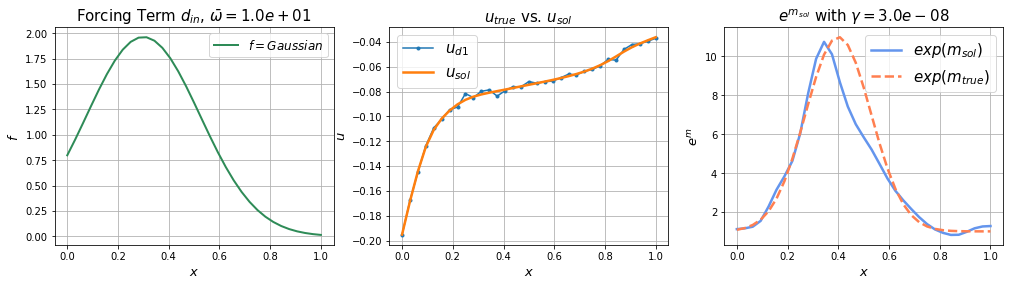

In [ ]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_NB_synth.eps', format='eps',dpi=250)
plt.show()

# Dirichlet Boundary Condition

In [ ]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [ ]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 10
oce_val = 0.0
gamma =3e-5
x = np.linspace(0,1,nx+1)

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

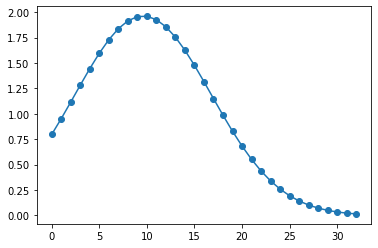

In [ ]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [ ]:
from numpy import cos, pi, sin, exp
u0L = 1.0#cos(0.0)*3*pi
u0R = 0.0 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.0


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

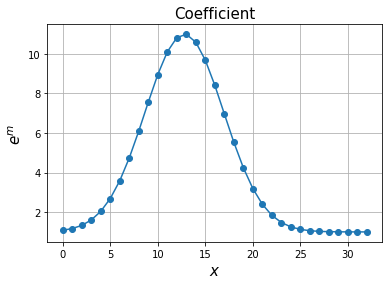

In [ ]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

data = {'forcing': run.f.compute_vertex_values().tolist(), 
        'mtrue': mtrue.compute_vertex_values().tolist(),
        'u_true': utrue_array.tolist(),
        'left_boundary': u0L,
        'right_boundary': u0R,
        'u_data': run.ud.compute_vertex_values().tolist(),
        }

import json
with open('data.json', 'w') as fp:
    json.dump(data, fp)

## Setup Data

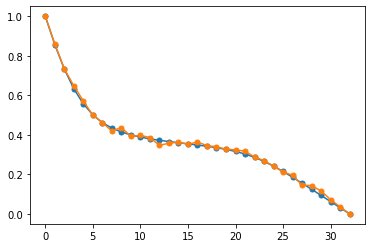

In [ ]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values())

plt.plot(utrue_array, 'o-',markersize=5)
plt.plot(run.ud.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

0.0
1.0


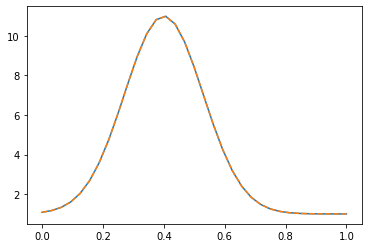

In [ ]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])

plt.plot(x, np.exp(m.compute_vertex_values()))
plt.plot(x, np.exp(mtrue.compute_vertex_values()),'--')

## Optimization Loop

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg


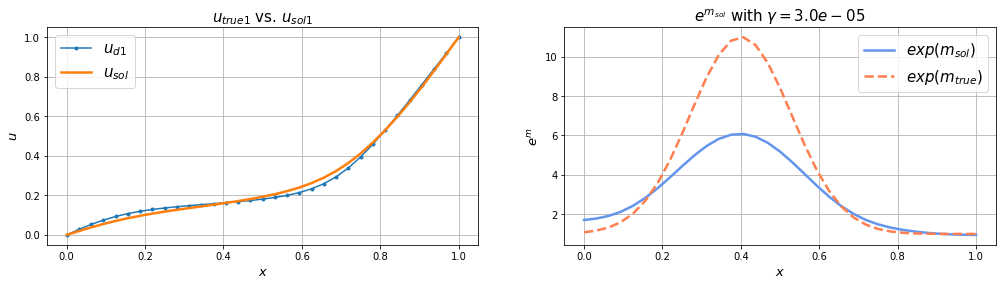

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     3     3.32776e-04   2.83733e-04   3.81819e-04   1.96192e-02   1.38907e-03   1.00e+00   5.000e-01


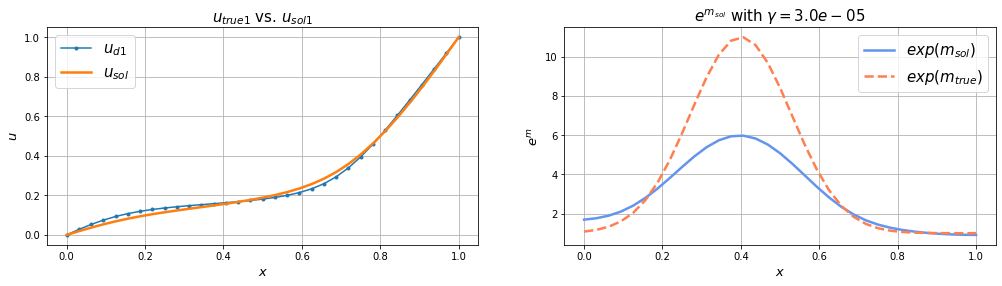

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 2     1     3.25084e-04   2.63743e-04   3.86425e-04   3.91362e-03   1.39303e-03   1.00e+00   5.000e-01


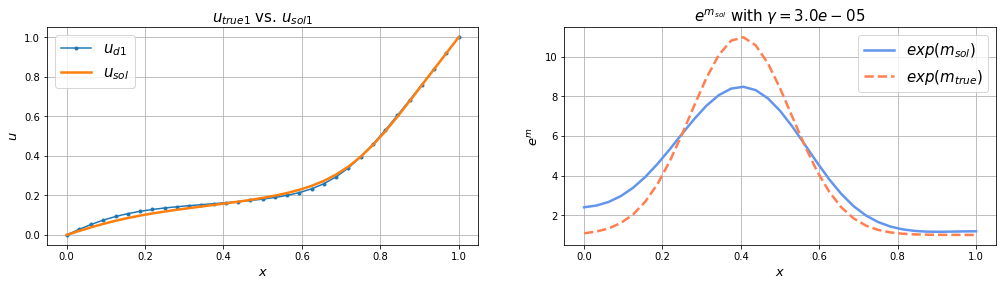

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 3     3     3.02476e-04   1.40263e-04   4.64690e-04   7.21858e-03   8.80221e-04   1.00e+00   5.000e-01


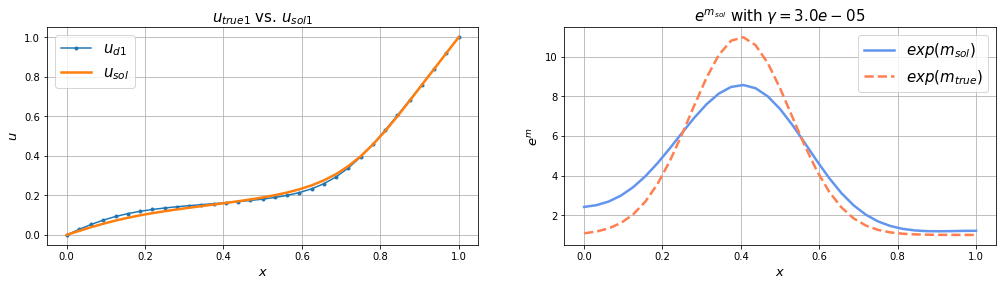

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 4     1     3.00732e-04   1.39099e-04   4.62365e-04   1.86510e-03   4.92773e-04   1.00e+00   3.548e-01


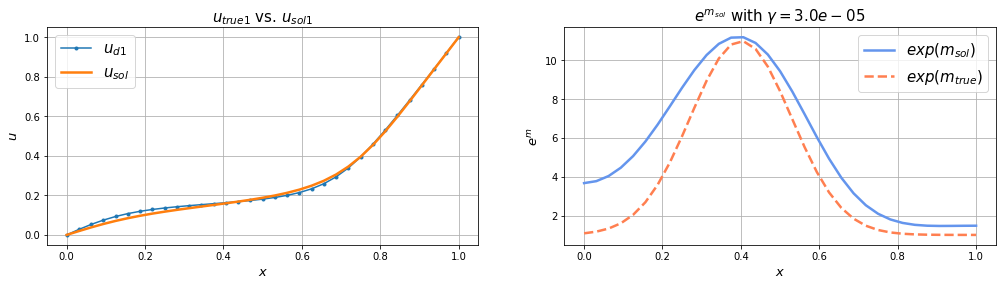

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 5     6     2.99520e-04   1.51571e-04   4.47469e-04   3.22905e-03   2.47896e-04   5.00e-01   1.785e-01


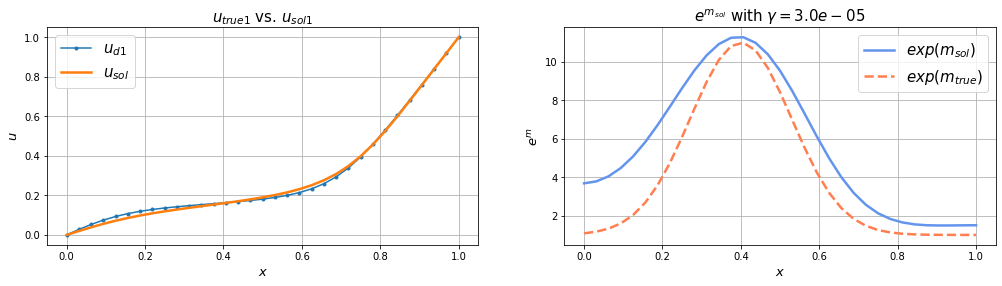

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 6     1     2.98049e-04   1.50880e-04   4.45218e-04   1.72104e-03   4.36267e-04   1.00e+00   3.141e-01


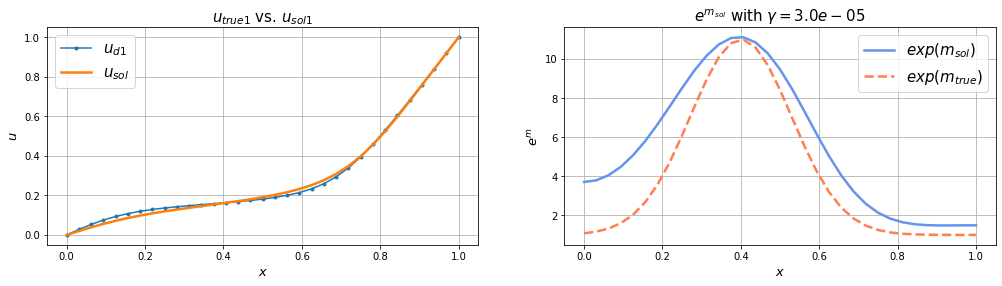

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 7     4     2.97736e-04   1.57966e-04   4.37506e-04   7.89934e-04   1.37565e-04   1.00e+00   9.903e-02


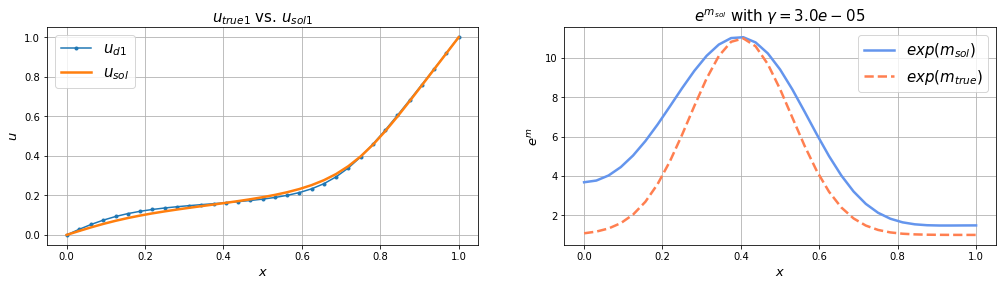

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 8     9     2.97735e-04   1.57893e-04   4.37576e-04   5.67527e-05   1.46304e-05   1.00e+00   1.053e-02


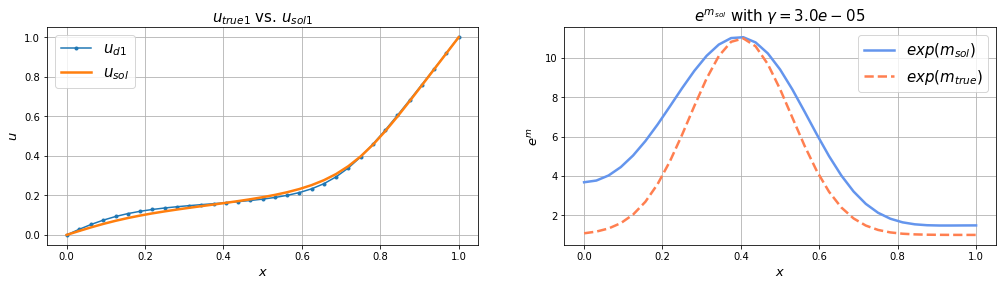

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 9    10     2.97735e-04   1.57892e-04   4.37577e-04   7.45277e-07   1.87008e-07   1.00e+00   1.346e-04


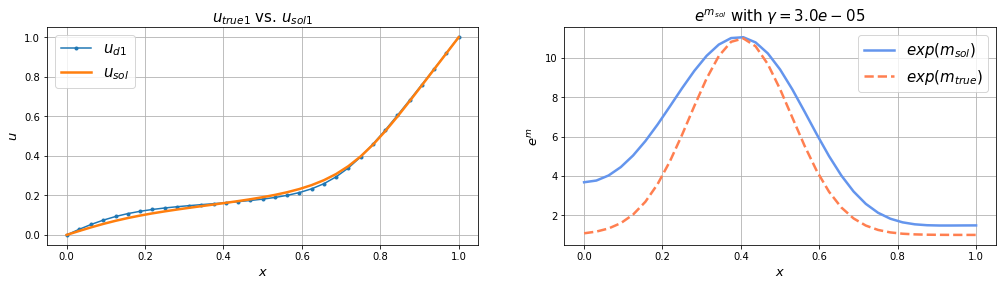

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
10    11     2.97735e-04   1.57892e-04   4.37577e-04   3.01982e-10   4.84885e-11   1.00e+00   3.491e-08
Newton's method converged in  10   iterations
Total number of CG iterations:  49


In [ ]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter, plot_opt_step=True)

In [ ]:
p, adjoint_A, _ = run.adj_solve(m, u)
Wum_equ, C_equ, Wmm_equ, M_equ = run.wf_matrices_setup(m,u,p)
C =  dl.assemble(C_equ)
CT_p = dl.Vector()
C.init_vector(CT_p,1)
C.transpmult(p.vector(), CT_p)
MG = CT_p + run.R * m.vector()

## Plotting Results

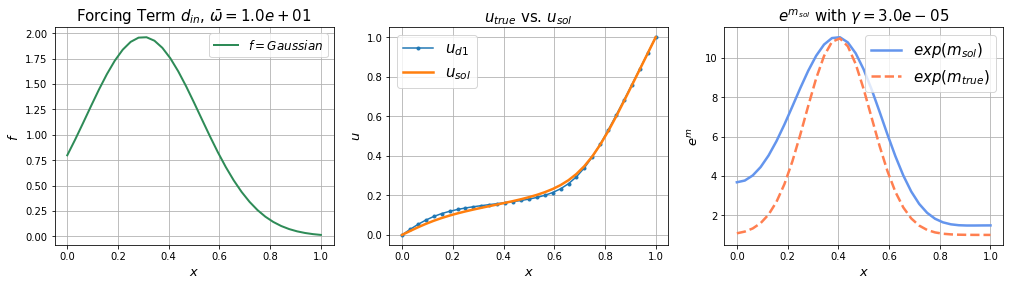

In [ ]:
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
plt.show()

## Symmetric Hessian Testing

In [ ]:
from utils.random import generate_random_vector
'''
Creat x and y vector and compute y^T H x and x^T H y. See if they are equal
'''
xx = dl.Function(run.Vm).vector()
yy = dl.Function(run.Vm).vector()
xx = generate_random_vector(xx,0.,1,None)
yy = generate_random_vector(yy,0.,1,None)

xtHy = run.Hess.inner(xx, yy)
ytHx = run.Hess.inner(yy, xx)

symm_diff = abs(xtHy-ytHx)
print(f'The symmetric difference is {symm_diff}')
if symm_diff < 1e-10:
    print('The Hessian ia symmetric')
else:
    print('The Hessian is not symmetric')

The symmetric difference is 1.5178830414797062e-18
The Hessian ia symmetric


In [ ]:
C = run.Hess.C.array()
Wum

array([-1.41553471e-06, -1.37907108e-06, -2.64984151e-06,  2.23057733e-06,
        1.62687142e-05,  2.34322255e-05,  2.68601733e-05, -1.42405595e-06,
       -2.47121369e-05, -5.19232559e-06,  3.10817140e-06,  7.83977405e-06,
        2.37425931e-05,  4.11756649e-05,  5.18171327e-05,  3.73571259e-05,
        1.87125174e-05,  1.03117251e-05, -9.78901313e-06, -2.24227578e-05,
       -1.42059172e-05, -7.32048803e-07,  3.44013704e-06, -1.08931068e-06,
       -2.58460978e-06,  4.89355618e-07,  2.57169355e-06, -8.75989570e-07,
        8.27150497e-07,  1.01856364e-05,  1.32119390e-05,  1.58647359e-05,
        9.90325749e-06])

In [ ]:
Wum[5]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.62814746e-04,  8.78547655e-05,  2.57698490e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [ ]:
A = run.Hess.A.array()
print('A')
print(np.allclose(A, A.T, atol=1e-10, rtol=1e-10))
A_adj = run.Hess.adj_A.array()
print('A_adj')
print(np.allclose(A_adj, A_adj.T, atol=1e-10, rtol=1e-10))
W = run.Hess.W.array()
print('W')
print(np.allclose(W, W.T, atol=1e-10, rtol=1e-10))
Wum = run.Hess.Wum.array()
print('Wum')
print(np.allclose(Wum, Wum.T, atol=1e-8, rtol=1e-8))

A
True
A_adj
True
W
True
Wum
False


In [ ]:
C = run.Hess.C.array()

array([[ 1.92142901,  1.92063024,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.92142901, -0.00206705,  1.91692998, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.91856319, -0.00367944, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.02603993,
         1.15861077,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.18454499,
         0.01450253,  1.16406551],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.17311329, -1.16406551]])

# Dual Data Problem

In [ ]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Initialization

In [ ]:
nx = 32
a,b = 0,1
omega = 10
oce_val1 = 0.0
oce_val2 = 0.0
gamma =3e-8

beta1 = 0.5
beta2 = 0.5

run = dual_data_run(nx, a, b, gamma, gamma, omega, omega, oce_val1, oce_val2, oce_val1, oce_val2, 'Lagrange', save_path='synthetic')
x = run.mesh.coordinates()

In [ ]:
a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str,a1_adj_str, L1_adj_str,  a2_state_str, L2_state_str,  a2_adj_str, L2_adj_str)

## Forcing Term

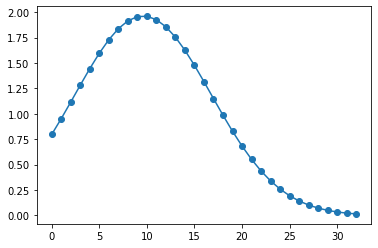

In [ ]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [ ]:
from numpy import cos, pi, sin, exp
u1L_D = 0.0#cos(0.0)*3*pi
u1R_D = 1.0 #cos(3*pi)*3*pi
u2L_N = 1.0
u2R_N = 0.1
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D}, NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.0, Dirichlet_R: 1.0, NBC_L: 1.0, NBC_R: 0.1


## $m_{true}$

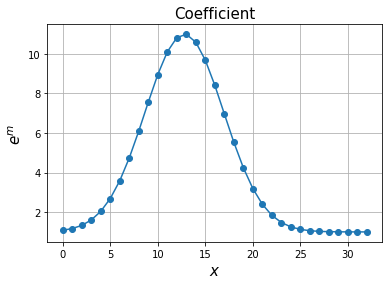

In [ ]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)
plt.show()

## Setup Data

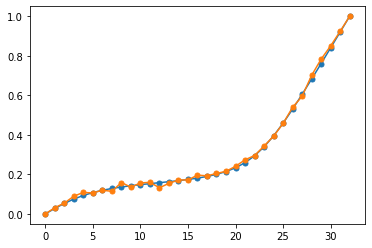

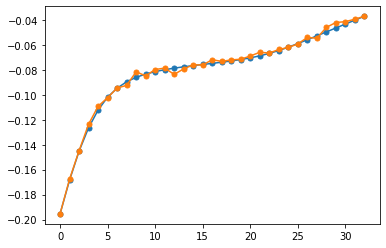

In [ ]:

noise_level = 0.01
ud1, ud2, goal_A1, goal_b1, goal_A2, goal_b2 = run.fwd_solve(m)
utrue1_array = ud1.compute_vertex_values()
utrue2_array = ud2.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud1, goal_A1)
np.random.seed(0)
apply_noise(noise_level, ud2, goal_A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(),normalize=False)

plt.plot(utrue1_array, 'o-',markersize=5)
plt.plot(run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
plt.plot(utrue2_array, 'o-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [ ]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u1,u2,_,_,_,_ = run.fwd_solve(m)
print(u1.compute_vertex_values()[0])
print(u1.compute_vertex_values()[-1])
print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())

0.0
1.0
0.487470582321186
0.05003529874780799


## Optimization Loop

In [ ]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")
print(dt_string)

20240410-170202


In [ ]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter)

AttributeError: 'dual_data_run' object has no attribute 'beta1'

## Plotting Results

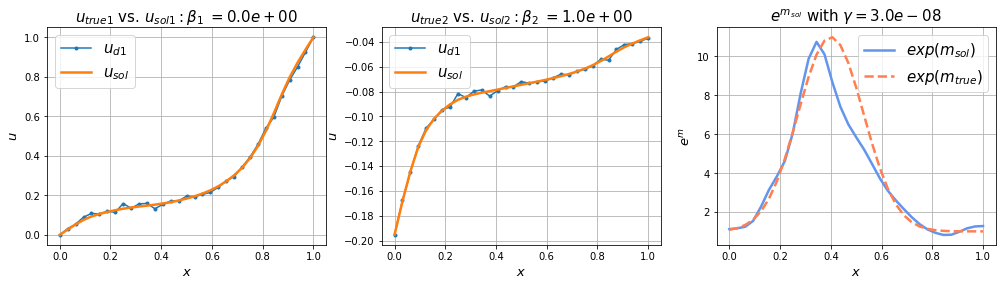

In [ ]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

# Construct a Dual Problem

## single data DBC or NBC

In [1]:
from helm_eq import single_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 1.0
oce_val = 1.0
gamma =1.043e-4 if bc_type == 'DBC' else 1.6e-3
# gamma = 1.0e-4
run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=0.0)
run.misfit_reg_setup(gamma)

if bc_type == 'DBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
elif bc_type == 'NBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

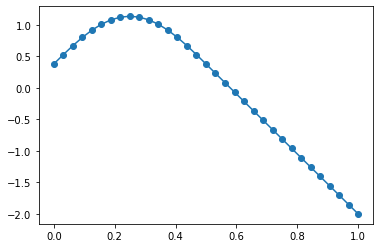

In [3]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()
if bc_type == 'DBC':
    y1[x>=0.5] = y_lin[x>=0.5]
elif bc_type == 'NBC':
    y1[x<=0.5] = y_lin[x<=0.5]
else:
    raise ValueError(f'Unknown BC type: {bc_type}')

def normalize_u(u_array):
    mean = np.mean(u_array)
    std = np.std(u_array)
    return (u_array - mean) / std, mean, std

y1, _, _ = normalize_u(y1)
dy1 = np.gradient(y1,x,edge_order=2)

plt.plot(x, y1, 'o-')

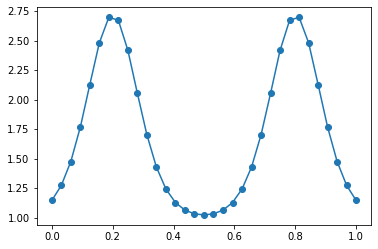

In [4]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


### Setup Forcing

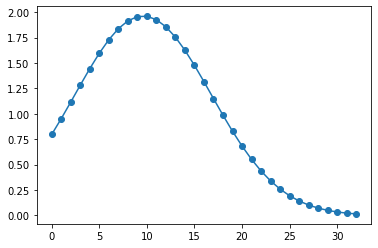

In [5]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

### Setup BC

In [6]:
uL = y1[0] if bc_type == 'DBC' else dy1[0] * np.exp(mtrue_array[0])
uR = y1[-1] if bc_type == 'DBC' else dy1[-1] * np.exp(mtrue_array[-1])
print(f'uL: {uL}, uR: {uR}')
run.BC_setup(uL, uR)

uL: 0.38035497335598545, uR: -2.0022128858133064


### Set up extra Forcing

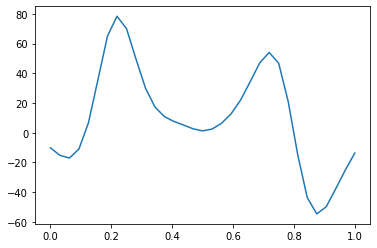

In [7]:
g_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g = dl.Function(run.Vu)
g.vector().set_local(g_array[::-1])
run.extra_f_setup(g = g)

plt.plot(x,run.g.compute_vertex_values())
plt.show()

### Setup Data


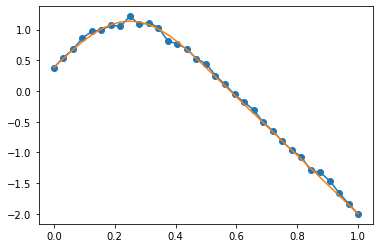

In [8]:
noise_level = 0.02
ud, goal_A, goal_b = run.fwd_solve(m_true)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(x, run.ud.compute_vertex_values(), 'o-')
plt.plot(x, y1)

### Initial Guess

0.38035497335598545
-2.0022128858133064
0.38035497335598545 -2.0022128858133064


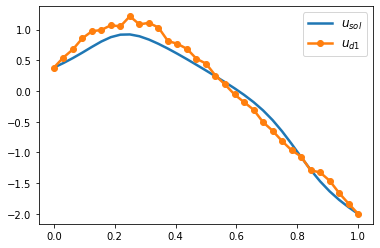

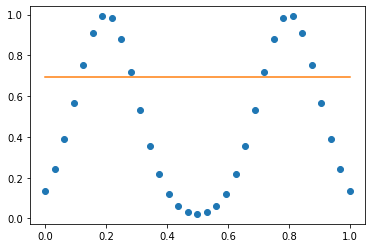

In [9]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
if bc_type == 'DBC':
    print(u.compute_vertex_values()[0])
    print(u.compute_vertex_values()[-1])
    print(y1[0], y1[-1])
elif bc_type == 'NBC':
    print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(mtrue_array[0]))
    print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(mtrue_array[-1]))
    print(uL, uR)

plt.plot(x,u.compute_vertex_values(), label=r'$u_{sol}$',linewidth=2.5)
plt.plot(x,run.ud.compute_vertex_values(),'o-', label=r'$u_{d1}$',linewidth=2.5)
plt.legend(prop={'size':12})
plt.show()

plt.plot(x,mtrue_array, 'o')
plt.plot(x, m.compute_vertex_values())

### Optimization Loop

In [10]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter,plot_opt_step=False, save_opt_log=False)

Nit   CGit   cost          misfit        reg         rel_gradnorm    (G*D)/(l)       ||grad||       alpha      tolcg      min(eigval)
Transposed is only defined for rank 2 tensors.
Transposed is only defined for rank 2 tensors.


: 

In [ ]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,3),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

# ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
# ax[0].grid('on')
# ax[0].set_xlabel(r'$x$', fontsize=13)
# ax[0].set_ylabel(r'$f$', fontsize=13)
# ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# # ax[0].legend()
# ax[0].legend(prop={'size':12})

if bc_type == 'DBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{dT}$', markersize=5)
    label = r'$u_{T}$'
elif bc_type == 'NBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{dS}$', markersize=5)
    label = r'$u_{S}$'
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)

ax[0].plot(x, u.compute_vertex_values(), 'o-', markersize=5, label=label,linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true}$ vs. $u_{sol}$: '+ f'{bc_type}', fontsize=15)
ax[0].legend(prop={'size':15})

text = ax[1].yaxis.get_offset_text()
text.set_fontsize(8)
# ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
# ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$e^m$', fontsize=13)
ax[1].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
eps = True
if not eps:
    if bc_type == 'DBC':
        plt.savefig(f'./log/img/helm_DB_synth.png',dpi=250)
    elif bc_type == 'NBC':
        plt.savefig(f'./log/img/helm_NB_synth.png',dpi=250)
else:
    if bc_type == 'DBC':
        plt.savefig(f'./log/img/helm_DB_synth.eps',format='eps',dpi=250,bbox_inches='tight')
    elif bc_type == 'NBC':
        plt.savefig(f'./log/img/helm_NB_synth.eps',format='eps',dpi=250,bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


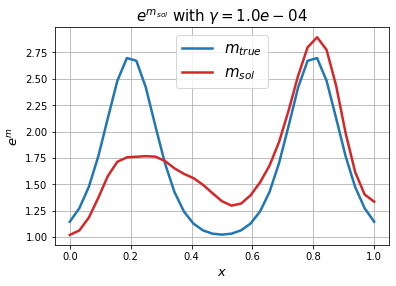

In [ ]:
plt.plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
plt.plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
plt.grid('on')
plt.xlabel(r'$x$', fontsize=13)
plt.ylabel(r'$e^m$', fontsize=13)
plt.title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
plt.legend(prop={'size':15})
plt.savefig(f'./log/img/helm_{bc_type}_synth.eps',format='eps',dpi=250)

### Eigenvalue of Hess

In [ ]:
k = run.nx
lmbda, evecs = run.eigenvalue_request(m, p=20)
if bc_type == 'DBC':
    DBC_eig = lmbda.copy()
elif bc_type == 'NBC':
    NBC_eig = lmbda.copy()
else:
    raise ValueError(f'Unknown BC type: {bc_type}')

# plt.plot(range(0,k+1), np.ones(k+1), '-r')
# plt.plot(range(0,k), lmbda, 'b*')
# if 'DBC_eig' in locals():
#     plt.plot(range(0,k), DBC_eig, '*', label='DBC Hess Eig')
# if 'NBC_eig' in locals():
#     plt.plot(range(0,k), NBC_eig, '*', label='NBC Hess Eig')
# plt.legend()
# plt.yscale('log')
# plt.xlabel('number')
# plt.ylabel('eigenvalue')

NameError: name 'gamma' is not defined

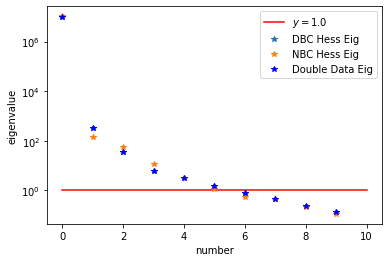

In [125]:
cutoff_num = 1.0
# print(f'num DBC_eig (eig>{cutoff_num}): ', sum(DBC_eig-1>=cutoff_num))
# print(f'num NBC_eig (eig>{cutoff_num}): ', sum(NBC_eig-1>=cutoff_num))
# print(f'num dual_eig (eig>{cutoff_num}): ', sum(dual_eig-1>=cutoff_num))

k = 10
plt.plot(range(0,k+1), np.ones(k+1)*cutoff_num, '-r',label=f'$y={cutoff_num}$')
if 'DBC_eig' in locals():
    plt.plot(range(0,k), (DBC_eig-1)[:k], '*', label='DBC Hess Eig')
if 'NBC_eig' in locals():
    plt.plot(range(0,k), (NBC_eig-1)[:k], '*', label='NBC Hess Eig')
if 'dual_eig' in locals():
    plt.plot(range(0,k), (dual_eig-1)[:k], 'b*', label='Double Data Eig')
# plt.ylim([0.5,1.5])
plt.legend()
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')
plt.title(f'Eigenvalues of Hessian: $\gamma = {gamma:1.1e}$')
# plt.savefig('./log/img/eigenvalues_singledata.eps', format='eps',dpi=250)
plt.show()

plt.plot(evecs[0])

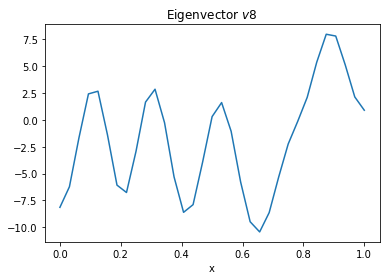

In [ ]:
idx = 8
plt.plot(x,evecs[idx])
plt.xlabel('x')
plt.title(f'Eigenvector $v{idx}$')
plt.savefig(f'./log/img/{bc_type}_eigvec{idx}.eps', format='eps', bbox_inches='tight',dpi=300)
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps',dpi=250)

## Double Data 

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

### Initialization


In [2]:
nx = 32
a,b = 0,1
omega = 1.0
oce_val = 0.0
gamma1 = 1.0e-4 #1.048e-4
gamma2 = 1.0e-4 #1.6e-3
print(f'gamma1   = {gamma1}, gamma2 = {gamma2}')
run = dual_data_run(nx,a,b,gamma1, gamma2, omega,omega,oce_val,oce_val, normalized_mean1=0.0, normalized_mean2=0.0)

beta1 = 1.0
beta2 = 0.0
if beta1 == 1.0 and beta2 == 0.0:
    gamma = 1.043e-4
elif beta1 == 0.0 and beta2 == 1.0:
    gamma = 1.6e-3
elif beta1 == 0.5 and beta2 == 0.5:
    gamma = None
else:
    raise ValueError
run.misfit_reg_setup(beta1, beta2, gamma=None)

a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx + self.g1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx + self.g2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str, a1_adj_str, L1_adj_str, a2_state_str, L2_state_str, a2_adj_str, L2_adj_str)

gamma1   = 0.0001, gamma2 = 0.0001


### Set up $u_{data}$ without noise

y1 mean: -1.3457248783335231e-17, y1 std: 1.3185742607495525
y2 mean: 1.682156097916904e-17, y2 std: 1.3185742607495528


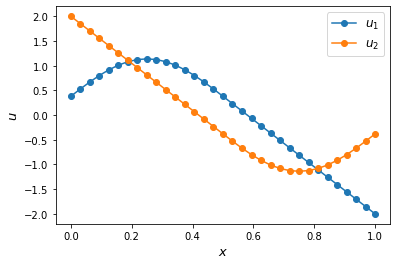

In [3]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()

y1[x>=0.5] = y_lin[x>=0.5]
y2[x<=0.5] = y_lin[x<=0.5]


def normalize_u(u_array):
    mean = np.mean(u_array)
    std = np.std(u_array)
    return (u_array - mean) / std, mean, std


y1, y1_mean, y1_std = normalize_u(y1)
y2, y2_mean, y2_std = normalize_u(y2)

print(f'y1 mean: {y1.mean()}, y1 std: {y1_std}')
print(f'y2 mean: {y2.mean()}, y2 std: {y2_std}')

    
dy1 = np.gradient(y1,x,edge_order=2)
dy2 = np.gradient(y2,x,edge_order=2)

plt.plot(x, y1, 'o-', label=r'$u_1$')
plt.plot(x, y2, 'o-', label=r'$u_2$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$u$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt.eps', bbox_inches='tight',format='eps')
plt.show()

### Setup $m_{true}$

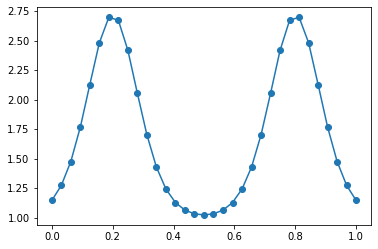

In [4]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


### Setup Forcing

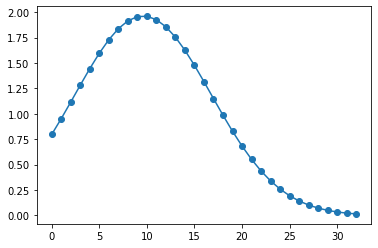

In [5]:

from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

### BC setup

In [6]:
from numpy import cos, pi, sin, exp
u1L_D = y1[0]
u1R_D = y1[-1]
u2L_N = dy2[0] * np.exp(mtrue_array[0])
u2R_N = dy2[-1] * np.exp(mtrue_array[-1])
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D},')
print(f'NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.38035497335598545, Dirichlet_R: -2.0022128858133064,
NBC_L: -5.455702010876427, NBC_R: 5.5248712770988275


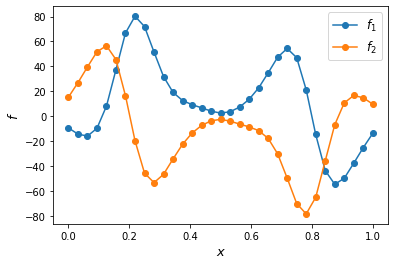

In [7]:
g1_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g1 = dl.Function(run.Vu)
g1.vector().set_local(g1_array[::-1])

g2_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y2, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y2 - oce_val)
g2 = dl.Function(run.Vu)
g2.vector().set_local(g2_array[::-1])
run.extra_f_setup(g1 = g1, g2 = g2)

plt.plot(x,run.g1.compute_vertex_values(),'o-',label=r'$f_1$')
plt.plot(x,run.g2.compute_vertex_values(),'o-',label=r'$f_2$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$f$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt_forcing.eps', bbox_inches='tight',format='eps')
plt.show()

### Data Setup

-0.1367524594063987


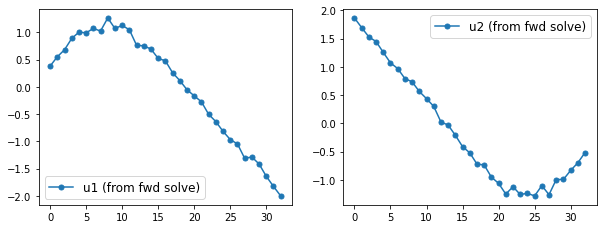

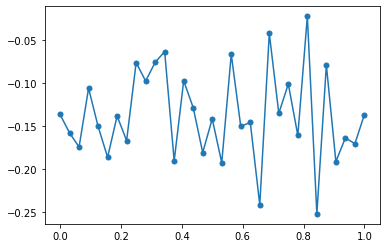

In [8]:
noise_level = 0.03

run.data_setup(y1, y2 ,normalize=False)
from utils.general import apply_noise
ud1, ud2, A1, b1, A2, b2 = run.fwd_solve(m_true)
np.random.seed(0)
apply_noise(noise_level, ud1, A1)
np.random.seed(1)
apply_noise(noise_level, ud2, A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(), normalize=False)


# plt.plot(y1, '-',markersize=5)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,3.6),sharey=False)
print(np.mean(run.ud2.compute_vertex_values()))
# ax[0].plot(y1, '-',markersize=5, label='y1 generated')
ax[0].plot(run.ud1.compute_vertex_values(), 'o-',markersize=5, label='u1 (from fwd solve)')
ax[0].legend(prop={'size':12})
# plt.show()
# ax[1].plot(y2, '-',markersize=5, label='y2 generated')
ax[1].plot(run.ud2.compute_vertex_values(), 'o-',markersize=5, label='u2 (from fwd solve)')
ax[1].legend(prop={'size':12})
plt.show()
plt.plot(x, run.ud2.compute_vertex_values() - y2, 'o-',markersize=5)

In [9]:
print(f'exchange mean: {np.mean(forcing_array* omega * (y2 - oce_val))}')
# check if boundary condition satisfied
print(f'NBC_L: {u2L_N}, NBC_R: {u2R_N}')
computed_NBC_L = np.exp(mtrue_array[0]) * (run.ud2.compute_vertex_values()[1] - run.ud2.compute_vertex_values()[0])/run.mesh.hmax() 
computed_NBC_R = np.exp(mtrue_array[-1]) * (run.ud2.compute_vertex_values()[-1] - run.ud2.compute_vertex_values()[-2])/run.mesh.hmax()
print(f'computed, NBC_L: {computed_NBC_L}, NBC_R: {computed_NBC_R}')
lhs_val = -u2R_N + u2L_N + np.mean(forcing_array* omega * (y2 - oce_val))
print(f'LHF: {lhs_val}')
g2_mean = np.mean(run.g2.compute_vertex_values())
print(f'g2 mean: {g2_mean}')
print(f'diff = {lhs_val - g2_mean}')

exchange mean: 0.43010116493989614
NBC_L: -5.455702010876427, NBC_R: 5.5248712770988275
computed, NBC_L: -6.247822814769951, NBC_R: 6.662323402326511
LHF: -10.550472123035357
g2 mean: -9.989538807761186
diff = -0.5609333152741716


### Initial Guess

Text(0, 0.5, '$u_2$')

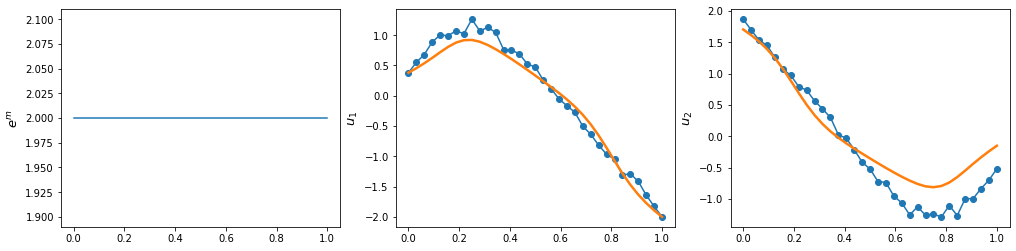

In [10]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(m_true)
u1,u2,_,_,_,_ = run.fwd_solve(m)
# print(u1.compute_vertex_values()[0])
# print(u1.compute_vertex_values()[-1])
# print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
# print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
ax[0].plot(x, np.exp(m.compute_vertex_values()))
ax[0].set_ylabel('$e^m$', fontsize=13)

ax[1].plot(x, run.ud1.compute_vertex_values(), '-o')
ax[1].plot(x, u1.compute_vertex_values(), linewidth=2.5)
ax[1].set_ylabel('$u_1$', fontsize=13)

ax[2].plot(x, run.ud2.compute_vertex_values(), '-o')
ax[2].plot(x, u2.compute_vertex_values(),linewidth=2.5)
ax[2].set_ylabel('$u_2$', fontsize=13)

### Sensitivity

0.75


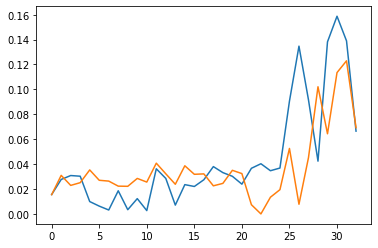

In [11]:
from utils.general import sensitivity_array
# mtrue_array = mtrue.compute_vertex_values()
utrue1_array = run.ud1.compute_vertex_values()
utrue2_array = run.ud2.compute_vertex_values()
dist_array = f.compute_vertex_values()
sensitivity1, _, _ = sensitivity_array(mtrue_array, utrue1_array, dist_array)
sensitivity2, _, _ = sensitivity_array(mtrue_array, utrue2_array, dist_array)

# X = Y = np.arange(0,1,1/33)
# X, Y = np.meshgrid(X, Y)

# %matplotlib widget
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(X, Y, sensitivity, cmap="viridis")

%matplotlib inline
i = 24 # this is at x = 0.75
# i = 9

print(i*run.mesh.hmax())
plt.plot(abs(sensitivity1[i,:]))
plt.plot(abs(sensitivity2[i,:]))

### Optimization Loop

In [12]:
run.gamma

0.00010000000000000009

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||      ||grad_rel||     |yTHx - xTHy|     alpha  tolcg
 1    209   1.03069e-02   2.06138e-02   6.27309e-09   7.55875e-02   7.54940e-02   1.00000e+00   1.39e-17   1.00e+00   5.000e-01
 2    106   4.10923e-03   8.16674e-03   5.17341e-05   1.11848e-01   8.01538e-02   1.06172e+00   8.33e-17   1.00e+00   5.000e-01
 3    105   4.07429e-03   8.09692e-03   5.16702e-05   8.36244e-03   2.62683e-02   3.47952e-01   8.33e-17   1.00e+00   3.480e-01
 4    109   2.11219e-03   3.39671e-03   8.27676e-04   6.71102e-02   2.38971e-02   3.16543e-01   1.94e-16   1.00e+00   3.165e-01
 5    105   1.80676e-03   2.78553e-03   8.27997e-04   2.47201e-02   3.60052e-02   4.76929e-01   4.16e-17   1.00e+00   4.769e-01
 6    109   1.61687e-03   2.31078e-03   9.22971e-04   1.94967e-02   9.49403e-03   1.25759e-01   2.36e-16   1.00e+00   1.258e-01
 7    114   1.57848e-03   2.04079e-03   1.11617e-03   8.76363e-03   2.47210e-03   3.27457e-02   1.11e

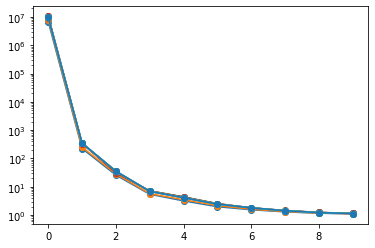

In [13]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter, save_opt_log=False, plot_opt_step=False, plot_eigval=False)

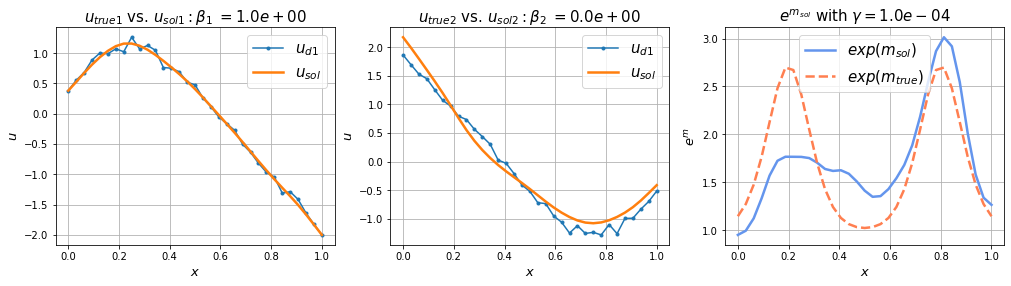

In [14]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {run.gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

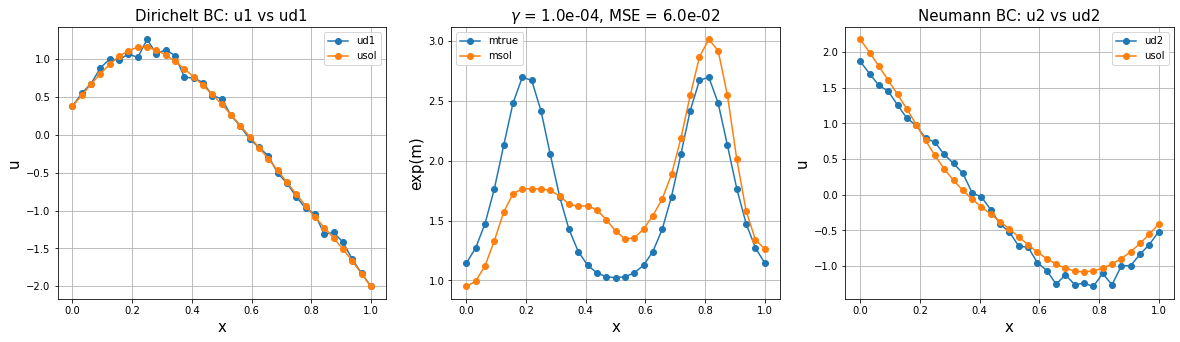

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) 
ax[0].plot(x,run.ud1.compute_vertex_values(), 'o-', label='ud1')
ax[0].plot(x,u1.compute_vertex_values(), 'o-', label='usol')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('u', fontsize=15)
ax[0].set_title('Dirichelt BC: u1 vs ud1', fontsize=15)
ax[0].grid()
ax[0].legend()

mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), 'o-', label='mtrue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), 'o-', label='msol')
ax[1].set_xlabel('x', fontsize=15)
ax[1].set_ylabel('exp(m)', fontsize=15)
ax[1].set_title(f'$\gamma$ = {run.gamma:1.1e}, MSE = {mse:1.1e}', fontsize=15)
ax[1].grid()
ax[1].legend()

ax[2].plot(x,run.ud2.compute_vertex_values(), 'o-', label='ud2')
ax[2].plot(x,u2.compute_vertex_values(), 'o-', label='usol')
ax[2].set_xlabel('x', fontsize=15)
ax[2].set_ylabel('u', fontsize=15)
ax[2].set_title('Neumann BC: u2 vs ud2', fontsize=15)
ax[2].grid()
ax[2].legend()

# plt.savefig('./log/img/dual_helm_synth.eps', format='eps', bbox_inches='tight')

2.3870141570242454


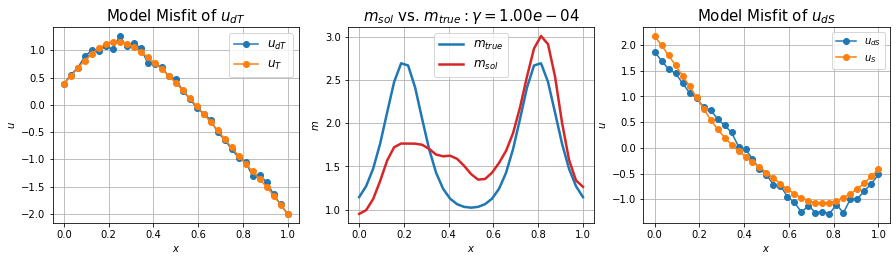

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(x,run.ud1.compute_vertex_values(), 'o-', label=r'$u_{dT}$')
ax[0].plot(x,u1.compute_vertex_values(), 'o-', label=r'$u_{T}$')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(r'Model Misfit of $u_{dT}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(r'$m_{sol}$ vs. $m_{true}$'+f'$: \gamma = {run.gamma:1.2e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].plot(x,run.ud2.compute_vertex_values(), 'o-', label=r'$u_{dS}$')
ax[2].plot(x,u2.compute_vertex_values(), 'o-', label=r'$u_{S}$')
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$u$')
ax[2].set_title(r'Model Misfit of $u_{dS}$', fontsize=15)
ax[2].grid()
ax[2].legend()

print(np.linalg.norm(np.exp(m_true.compute_vertex_values()) - np.exp(m.compute_vertex_values())))
# plt.savefig('./log/img/dual_helm_synth.png', bbox_inches='tight',dpi=300)
# plt.savefig('./log/img/dual_helm_synth.eps', format='eps', bbox_inches='tight',dpi=300)

### EigenVal

DBC updated


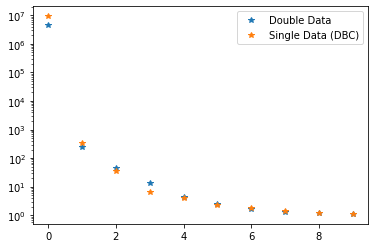

In [33]:
lmbda, evecs = run.eigenvalue_request(m, p=20)
idx = 10  # number of eigenvalues saved for plotting 
if beta1 == 0.5 and beta2 == 0.5:
    print('double data updated')
    double_data_eig = lmbda[:idx]
    double_data_first_eig_vec = evecs[0]
elif beta1 == 1.0:
    if beta2 == 0.0:
        print('DBC updated')
        DBC_eig = lmbda[:idx]
        DBC_first_eig_vec = evecs[0]
    else:
        raise ValueError('beta2 must be 0.0')
elif beta1 == 0.0:
    if beta2 == 1.0:
        print('NBC updated')
        NBC_eig = lmbda[:idx]
        NBC_first_eig_vec = evecs[0]
    else:
        raise ValueError('beta2 must be 1.0')
else:
    raise ValueError('beta1 must be 0.0 or 1.0')


if 'double_data_eig' in locals():
    plt.semilogy(double_data_eig[:idx], '*', label = 'Double Data')
if 'DBC_eig' in locals():
    plt.semilogy(DBC_eig[:idx], '*', label = 'Single Data (DBC)')
if 'NBC_eig' in locals():
    plt.semilogy(NBC_eig[:idx], '*', label = 'Single Data (NBC)')
plt.legend()

Text(0.5, 1.0, 'Eigenvector $v3$')

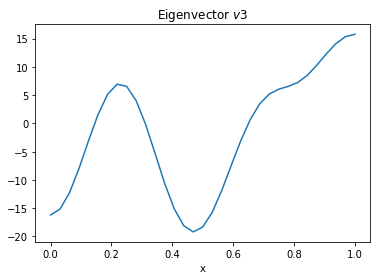

In [34]:
idx = 3
plt.plot(x,evecs[idx])
plt.xlabel('x')
plt.title(f'Eigenvector $v{idx}$')
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps', bbox_inches='tight',dpi=300)
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps',dpi=250)

In [35]:
test1 = np.array([1.2123])
print(f'{test1.item()}')

1.2123


Text(0.5, 1.0, 'Sensitivity of $u(x)$ w.r.t. m(x=0.75)')

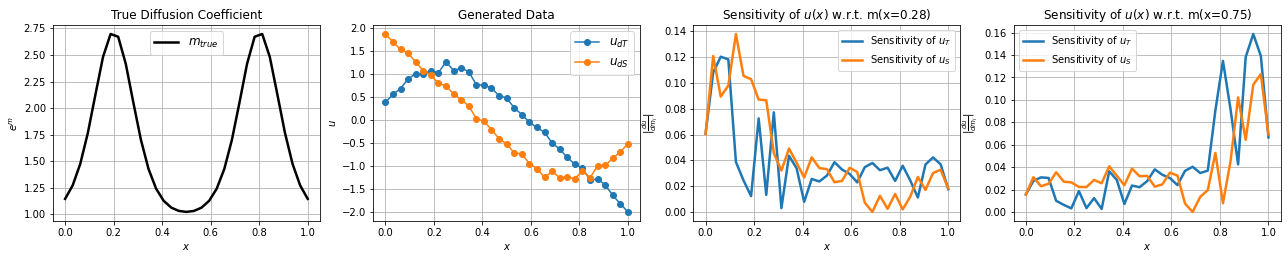

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(22, 3.6))

ax[0].plot(x, np.exp(mtrue_array), 'k', label='$m_{true}$', linewidth=2.5)
ax[0].legend(fontsize=12)
ax[0].set_title('True Diffusion Coefficient')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$e^m$')
ax[0].grid()

ax[1].plot(x, run.ud1.compute_vertex_values(), 'o-', label=r'$u_{dT}$', linewidth=1.5)
ax[1].plot(x, run.ud2.compute_vertex_values(), 'o-', label=r'$u_{dS}$', linewidth=1.5)
ax[1].legend(fontsize=12)
ax[1].set_title('Generated Data')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u$')
ax[1].grid()

idx = 9
x_val = run.mesh.hmax() * idx
ax[2].plot(x, abs(sensitivity1[idx]), label=r'Sensitivity of $u_T$', linewidth=2.5)
ax[2].plot(x, abs(sensitivity2[idx]), label=r'Sensitivity of $u_S$', linewidth=2.5)
ax[2].set_ylabel(r'$|\frac{du}{dm_i}|$')
ax[2].set_xlabel(r'$x$')
ax[2].legend(fontsize=10)
ax[2].grid()
ax[2].set_title(f'Sensitivity of $u(x)$ w.r.t. m(x={x_val:.2f})')

idx = 24
x_val = run.mesh.hmax() * idx
ax[3].plot(x, abs(sensitivity1[idx]), label=r'Sensitivity of $u_T$', linewidth=2.5)
ax[3].plot(x, abs(sensitivity2[idx]), label=r'Sensitivity of $u_S$', linewidth=2.5)
ax[3].set_ylabel(r'$|\frac{du}{dm_i}|$')
ax[3].set_xlabel(r'$x$')
ax[3].legend(fontsize=10)
ax[3].grid()
ax[3].set_title(f'Sensitivity of $u(x)$ w.r.t. m(x={x_val:.2f})')

# plt.savefig('./log/img/double_data_setupt_sensitivity.eps', format='eps', bbox_inches='tight',dpi=300)

# Flat region within Domain

## Initialization

In [1]:
from helm_eq import single_data_run

import dolfin as dl 
import ufl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

nx = 1024
print(nx)
a,b = 0,1
bc_type = 'DBC'
omega = 1.0
oce_val = 0.0
gamma =1.0e-8
x = np.linspace(0,1,nx+1)

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
# === poisson ===
# a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx'
# L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx'
# a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx'
# L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

1024


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

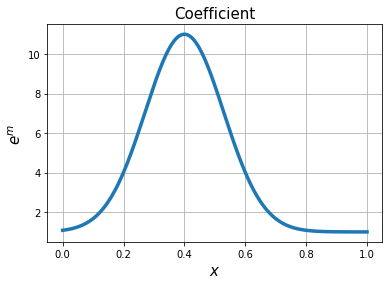

In [2]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::sin(pow(x[0],2)*5*pi)'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue =  dl.interpolate(mtrue_expression,run.Vm)
mtrue_array = mtrue.compute_vertex_values()
# mtrue.vector().set_local(mtrue_array)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
# run.bc_adj.apply(mtrue.vector())
# plt.plot(x,mtrue.compute_vertex_values())
plt.plot(x,np.exp(mtrue.compute_vertex_values()), '-',linewidth=3.5)
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)



## Set up $d$ distribution I called $f$

Text(0.5, 1.0, 'Distribution $d(x)$')

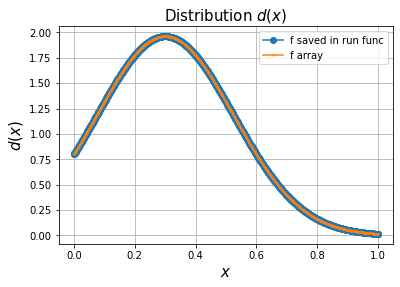

In [3]:
from utils.general import normalize_function
c_1 = 1
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
# f_str = '1'
# f = dl.interpolate(dl.Expression(f_str, degree=2), run.Vm)
f = normalize_function(f_str, run.Vm, ufl.dx)
f_array = f.compute_vertex_values()
run.f_setup(f)

plt.plot(x,run.f.compute_vertex_values(), 'o-', label = 'f saved in run func')
plt.plot(x,f_array, 'o-', markersize=1, label='f array')
plt.legend()
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$d(x)$', fontsize=15)
plt.title('Distribution $d(x)$',fontsize=15)
# plt.savefig('./log/img/distribution.eps', format='eps', bbox_inches='tight',dpi=300)

## Setup Data AND it's forcing

### Setup $u$
Let $u$ be $\sin(x)$ between $-1$ and $1$. This is simply because it's nicer to see but I can shift it to be between $0$ and $1$ if all I care about is the numerical solution at the end.

In [4]:
x_test = np.linspace(-1,1,x.shape[0])

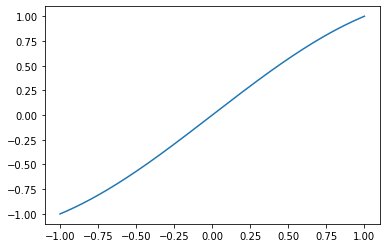

In [5]:
u_true_pre_adj = 2*np.sin(x_test)
u_true_pre_adj /= np.max(abs(u_true_pre_adj))
plt.plot(x_test,u_true_pre_adj)

### Get the sinusoidal adjustment function 

Text(0.5, 1.0, 'Sigmoid$(x)$ with k=5')

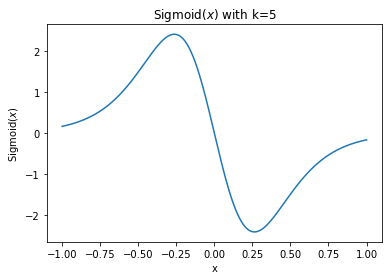

In [6]:
def sigmoid(x,k=1):
    return 1/(1+np.exp(-k*x))

def sigmoid_dx2(x,k=1):
    return k**2 * sigmoid(x,k) * (1-sigmoid(x,k)) * (1-2*sigmoid(x,k))

k = 5
plt.plot(x_test,sigmoid_dx2(x_test,k=k))
plt.xlabel('x')
plt.ylabel(r'Sigmoid$(x)$')
plt.title(f'Sigmoid$(x)$ with k={k}')

Text(0.5, 1.0, 'Adjusted Function with $\\beta$=-0.0')

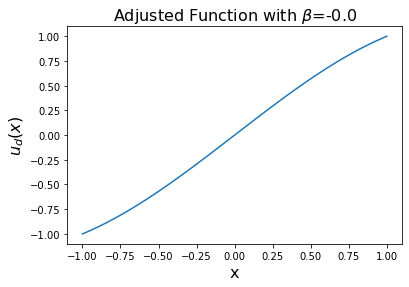

In [7]:
beta = -0.00
adj_func = beta*sigmoid_dx2(x_test,k=5)
u_true = u_true_pre_adj + adj_func

plt.plot(x_test, u_true)
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$u_d(x)$', fontsize=16)
plt.title(f'Adjusted Function with '+r'$\beta$'+f'={beta}', fontsize=16)

## Find extra forcing

Text(0.5, 1.0, 'Solar Term')

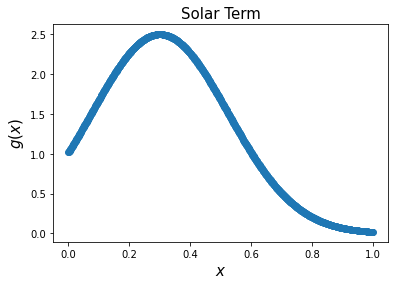

In [8]:
# du = np.gradient(u_true_pre_adj,x)
# m_array = mtrue.compute_vertex_values()
# emdu = np.exp(m_array)*du
# demdu = np.gradient(emdu,x)
# g_array = omega * f_array*u_true_pre_adj - demdu
# plt.plot(x, g_array)
# g = dl.Function(run.Vm)
# g.vector().set_local(g_array[::-1])
# plt.plot(x, g.compute_vertex_values())

# check for consistency with the way g(x) solar term is saved
c_1 = 2.5
peak_loc = 0.2
gauss_var = 1/50
# g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
g_str = f_str + f' * {c_1}'
# g_str = 'std::exp(-5 * x[0]-1)'
# g_str = f'1 * {c_1}'
g = dl.Expression(g_str, degree=5)
g = dl.interpolate(g,run.Vm)
g_sun_true = g.compute_vertex_values()
# g.vector().set_local(g_sun_true)


run.extra_f_setup(g_sun=g)
plt.plot(x,run.g_sun.compute_vertex_values(), 'o-')
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$g(x)$', fontsize=15)
plt.title('Solar Term',fontsize=15)
# plt.savefig('./log/img/solar_term2.eps', format='eps', bbox_inches='tight',dpi=300)

## Apply Boundary

In [9]:
from numpy import cos, pi, sin, exp
u0L = 0.5#cos(0.0)*3*pi
u0R = 1.0 #cos(3*pi)*3*pi
u0L = 1.0
u0R = 0.0
# u0L = u_true[0]
# u0R = u_true[-1]
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.0


## Set up Data

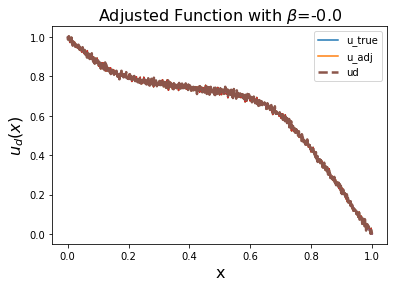

In [26]:
u,A,_ = run.fwd_solve(mtrue)
u_true = u.compute_vertex_values()
# assign u that I set up for adjustment within the domain
plt.plot(x, u_true, label='u_true')

# beta = -0.000
# adj_func = beta*sigmoid_dx2(x_test,k=5)
# u_true += adj_func

plt.plot(x, u_true, label='u_adj')
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$u_d(x)$', fontsize=16)
plt.title(f'Adjusted Function with '+r'$\beta$'+f'={beta}', fontsize=16)

np.random.seed(0)
noise_level = 0.01
MAX = u.vector().norm("linf")
noise = dl.Vector()
A.init_vector(noise, 1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(u.vector().get_local())) )
run.bc_adj.apply(noise)
u.vector().axpy(1.0, noise)

# max_norm = np.max(abs(u_true))
# noise = noise_level * max_norm * np.random.normal(0,1,u_true.shape)
# noise[0] = noise [-1] = 0
# ud_array = u_true + noise

plt.plot(x, u.compute_vertex_values())
ud = u.copy()
ud_array = ud.compute_vertex_values()
# ud = dl.Function(run.Vu)
# ud.vector().set_local(ud_array[::-1])
# ud.vector().set_local(np.zeros(len(ud_array)))
plt.plot(x, ud.compute_vertex_values())
plt.plot(x, u_true)
run.data_setup(ud = ud, normalize=False)
# run.data_setup(ud_array=ud_array)

plt.plot(x, run.ud.compute_vertex_values(),'--',  label='ud', linewidth=2.5)
plt.legend()

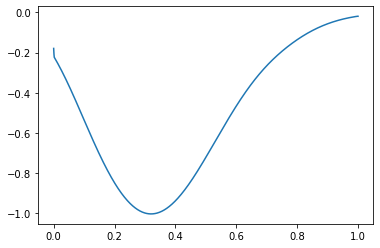

In [27]:
du = np.gradient(u_true, x, edge_order=2)
# plt.plot(x, du)
emdu = np.exp(mtrue.compute_vertex_values())*du
# plt.plot(x, emdu)
demdu = np.gradient(emdu,x, edge_order=2)
plt.plot(x, demdu)

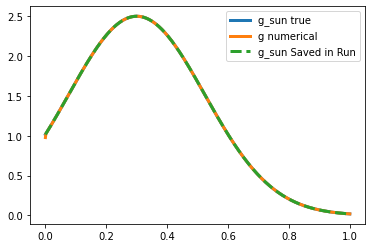

In [28]:
# plt.plot(x, -np.gradient(np.exp(mtrue_array)*np.gradient(u_true,x),x) + f_array*omega*(u_true))
g_numerical = -demdu + f_array*omega*(u_true)
# plt.plot(x, g_numerical, label='g numerical')
mesh = dl.UnitIntervalMesh(nx)
Func_Sp = dl.FunctionSpace(mesh,'Lagrange',1)
g_num_func_1poly = dl.Function(Func_Sp)
g_num_func_1poly.vector().set_local(g_numerical[::-1])
g_num_func = dl.interpolate(g_num_func_1poly, run.Vu)
# g_num_func = dl.Function(run.Vm)
# g_num_func.vector().set_local(g_numerical[::-1])
# run.extra_f_setup(g_sun=g_num_func) # don't use this is element is of order higher than 1
plt.plot(x, g_sun_true, label='g_sun true', linewidth=3)
plt.plot(x, g_num_func.compute_vertex_values(), label='g numerical', linewidth=3)
plt.plot(x, run.g_sun.compute_vertex_values(), '--',label='g_sun Saved in Run', linewidth=3)
plt.legend()


## Inital Guess

mean of e^mtrue:  4.229775498315576
1.0
0.0


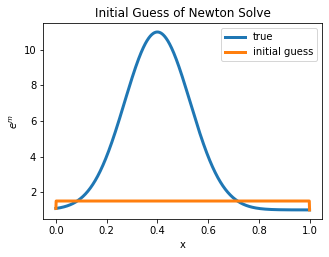

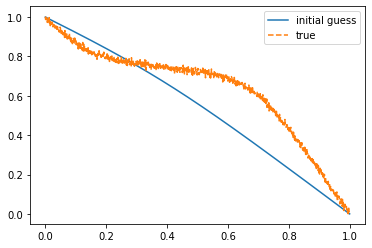

In [29]:
#initial guess m
print('mean of e^mtrue: ',np.exp(mtrue.compute_vertex_values()).mean())
m = dl.interpolate(dl.Expression("std::log(1.5)", degree=1),run.Vm)
# set m init to mtrue + noise
# m.assign(mtrue)
# np.random.seed(2)
# perturb_level = 0.03
# MAX = m.vector().norm("linf")
# init_m_perturb = dl.Vector()
# A.init_vector(init_m_perturb, 1)
# noise.set_local( perturb_level * MAX * np.random.normal(0, 1, len(m.vector().get_local())) )
# run.bc_adj.apply(init_m_perturb)
# m.vector().axpy(1.0, noise)
# m_init_array = mtrue.compute_vertex_values()
# idx = 50
# m_init_array[idx] *= 5
# m.vector().set_local(m_init_array[::-1])
# m = mtrue
from utils.general import DboundaryL, DboundaryR
bc_m = [dl.DirichletBC(run.Vm, mtrue_array[0],DboundaryL), dl.DirichletBC(run.Vm, mtrue_array[-1],DboundaryR)]
bc_m[0].apply(m.vector())
bc_m[1].apply(m.vector())

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])


plt.figure(figsize=(5,3.6))
plt.plot(x, np.exp(mtrue.compute_vertex_values()), label='true', linewidth=3)
plt.plot(x, np.exp(m.compute_vertex_values()), '-',label='initial guess',linewidth=3)
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$e^m$')
plt.title('Initial Guess of Newton Solve')
# plt.savefig('log/img/initial_guess.eps', bbox_inches='tight', format='eps', dpi=300)
plt.show()

plt.plot(x, u.compute_vertex_values(), label='initial guess')
plt.plot(x, ud.compute_vertex_values(), '--', label='true')
plt.legend()

## Optimization Loop

a = dl.dot(dl.grad(run.u_test), dl.grad(run.u_trial))*dl.dx
A = dl.PETScMatrix()
dl.assemble(a, tensor=A)

eigensolver = dl.SLEPcEigenSolver(A)

eigensolver.solve()


for i in range(nx+1):
    r, c, rx, cx = eigensolver.get_eigenpair(i)
    print(r)

In [30]:
tol = 1e-10
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter, plot_opt_step=False, save_opt_log=False)

Nit   CGit   cost          misfit        reg         rel_gradnorm    (G*D)/(l)       ||grad||       alpha      tolcg      min(eigval)
 1     3   3.96220e-03   7.90601e-03   1.83958e-05   1.00000e+00   1.59895e-01   3.86812e-02   1.00e+00   5.000e-01
 2     1   1.38238e-03   2.76074e-03   4.03192e-06   5.80392e-01   7.28610e-02   2.24503e-02   1.00e+00   5.000e-01
 3     7   4.37708e-04   8.68896e-04   6.52019e-06   1.58713e-01   7.67874e-02   6.13920e-03   2.50e-01   1.587e-01
 4     3   1.10333e-04   2.15763e-04   4.90355e-06   1.81329e-01   2.86913e-02   7.01403e-03   1.00e+00   1.813e-01
 5    11   5.76963e-05   1.02639e-04   1.27534e-05   7.10099e-02   1.31073e-02   2.74675e-03   1.00e+00   7.101e-02
 6    23   5.46537e-05   9.44833e-05   1.48240e-05   3.07483e-02   1.06455e-02   1.18938e-03   1.25e-01   3.075e-02
 7    22   3.96727e-05   7.15982e-05   7.74715e-06   2.88242e-02   7.09988e-03   1.11495e-03   5.00e-01   2.882e-02
 8    45   3.84227e-05   7.01103e-05   6.73520e-06   1

In [31]:
np.min(np.linalg.eig(run.Hess.Wmm.array())[0])
# bad_eig = run.eig_val.copy()
if hasattr(run, 'eig_val'):
    plt.semilogy(run.eig_val, label = 'good_eig')
    plt.legend()
else:
    print('no eig found. Nx too large')

no eig found. Nx too large


Inf norm of misfit: 0.15312335241730374


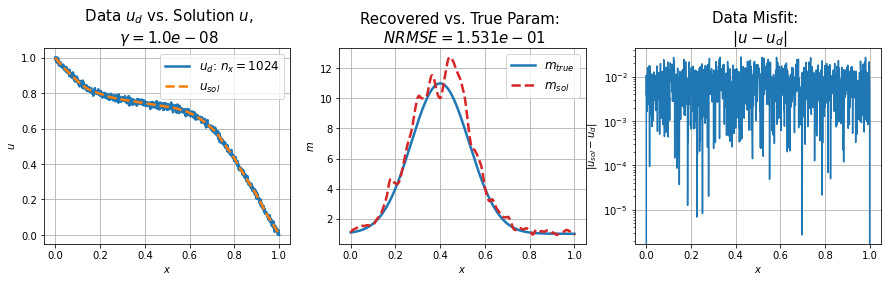

In [32]:
from utils.general import rmse,nmse
%matplotlib inline
# error, error_label = rmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array)), 'RMSE'
error, error_label = np.sqrt(nmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array))), 'NRMSE'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(x,ud.compute_vertex_values(), '-', label=f'$u_d$: $n_x = {nx}$', markersize=2, linewidth=2.5)
ax[0].plot(x,u.compute_vertex_values(), '--', label=r'$u_{sol}$', markersize=2, linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(f' Data $u_d$ vs. Solution $u$, \n $\gamma = {run.gamma:1.1e}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

ax[1].plot(x,np.exp(mtrue_array), '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
ax[1].plot(x,np.exp(m.compute_vertex_values()), '--', label=r'$m_{sol}$', color='tab:red', linewidth=2.5)
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(f'Recovered vs. True Param: \n ${error_label}={error:.3e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].semilogy(x, abs(ud.compute_vertex_values() - u.compute_vertex_values()))
# ax[2].plot(x, run.g_sun.compute_vertex_values())
ax[2].set_title(f'Data Misfit: \n $|u - u_d|$', fontsize=15)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$|u_{sol} - u_d|$')
ax[2].grid()

# ax[2].loglog(misfit, reg/gamma, 'o')
# ax[2].plot(misfit[kappa_min_ind], reg[kappa_min_ind]/gamma[kappa_min_ind], 'ro', label = f'gamma = {gamma[kappa_min_ind]:.3e}')
# ax[2].set_xlabel(r'$||u_{sol} - u_d||_2$')
# ax[2].set_ylabel(r'$||\nabla m||_2$')
# ax[2].set_title(r'L-Curve: Opt $\gamma$ Selection', fontsize=15)
# # ax[2].grid()
# ax[2].legend()
# plt.savefig(f'log/img/bad_conditioned_exp_true_initial_guess.eps', bbox_inches='tight', format='eps', dpi=300)

print(f'Inf norm of misfit: {error}')

Text(0.5, 1.0, 'RHS Forcing')

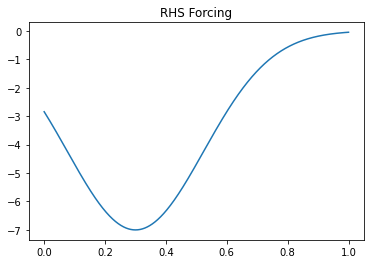

In [46]:
plt.plot(x, run.g_sun.compute_vertex_values())
plt.title('RHS Forcing')

## Plot Contour

In [42]:
def projection(v, u):
    '''Projection of v onto u.'''
    return u * (v @ u) / (u @ u)

## Unit Testing
v_vec = np.array([1,2,3])
u_vec = np.array([1,0,0])
proj_v = projection(v_vec, u_vec)
print((v_vec-proj_v) @ u_vec)

0.0


In [37]:
# list of value for two parameters
a_coe_list = np.linspace(-.5, 1.5, 51)
beta_list = np.linspace(-.1, .1, 51)

# create grid for 2D plotting of the parameterized equation
Alpha, Beta = np.meshgrid(a_coe_list, beta_list)
cost_grid = np.zeros(Alpha.shape)
cost_of_a_coe = []
m_true_array = mtrue_array.copy()
m_sol_array = m.compute_vertex_values().copy()
true_mean, true_std = np.mean(mtrue_array), np.std(mtrue_array)
print(true_mean, true_std)
np.random.seed(0)
m_perp_array = np.random.normal(0, true_std, len(mtrue_array))

# gram schmidt process
# m_sol_array = m_sol_array - projection(m_sol_array, mtrue_array)
# m_perp_array = m_perp_array - projection(m_perp_array, mtrue_array) - projection(m_perp_array, m_sol_array)
# # checking for orthogonality
# eps = 1e-11
# print((abs(m_perp_array @ mtrue_array) < eps), (abs(m_perp_array @ m_sol_array) < eps))

# m_perp_array = np.ones_like(m_true_array)

for i,a_coe in enumerate(a_coe_list):
    for j,beta in enumerate(beta_list):
        # print(a_coe, beta)
        # beta=0
        m_array_test = a_coe * m_sol_array + (1-a_coe) * m_true_array
        m_array_test2 = a_coe * m_sol_array + (1-a_coe) * m_true_array + beta * m_perp_array
        m_el_test = dl.Function(run.Vm)
        m_el_test.vector().set_local(m_array_test2[::-1].copy())
        u_el_test,_,_ = run.fwd_solve(m_el_test)
        cost,_,_ = run.cost(u_el_test, m_el_test)
        if beta == 0:
            cost_of_a_coe.append(cost)
        # if Alpha[j,i] == a_coe and Beta[j,i] == beta:
        cost_grid[j,i] = cost
        # else:
        #     raise ValueError



1.059176989665383 0.8933012770250401


In [38]:
min, max = np.min(cost_grid), np.max(cost_grid)
level = np.linspace(min, max, 100)

My cost functional:
$$
J(u) = \frac{1}{2}\int_\Omega(u-u_d)^2\,dx + \frac{\gamma}{2}\int_\Omega |\nabla m|^2\,dx
$$
Parameterize my solution with local min $m_{sol}$ and global min $m_{true}$ with a scalar to allow visualization. Let $v_1 = u(m_{sol})$ and $v_2 = u(m_{true})$, we introduce a $\alpha$ such that
$$
m^* = \alpha m_{sol} + (1-\alpha)m_{true} + \beta m_3
$$
A separate vector $v_3$ is generated at random and as a nudge only to remain the feature of $v_1$ and $v_2$. The range of $\beta$ is, therefore, kept small. A contour plot is plotted by varying $\alpha$ and $\beta$.


In [39]:
np.min(cost_grid)

5.7537648976175404e-09

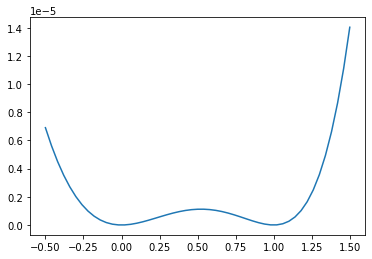

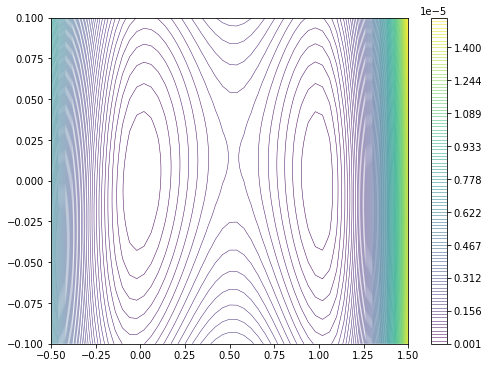

In [40]:
# plt.plot(a_coe_list, cost_of_a_coe)
# plt.plot(a_coe_list, cost_grid)
plt.plot(a_coe_list,cost_of_a_coe)
plt.show()

plt.figure(figsize=(8,6))
plt.contour(Alpha, Beta, cost_grid, levels=level, linewidths=0.5)
plt.colorbar()
plt.show()

In [ ]:
def FD_discretize_equation(D, d, f, x, lbc=0, rbc=0):
    """ 
    Discretizes the equation -d/dx (D(x) d/dx u) + d(x) u = f(x) using finite differences. -D(x) * d²u/dx² - D'(x) * du/dx + d(x) u
    """

    n = len(x)  # Number of points
    dx = x[1] - x[0] 

    # Initialize the A and b for the linear stuff (Au = b)
    A = np.zeros((n, n))
    b = np.zeros(n)

    dD = np.gradient(D, x, edge_order=2)

    # Interior points
    for i in range(1, n - 1):
        A[i, i - 1] = -D[i] / dx**2 + dD[i] / (2*dx)
        A[i, i] = D[i] * 2  / dx**2 + d[i]
        A[i, i + 1] = -D[i] / dx**2 - dD[i] / (2*dx)
        b[i] = f[i]

    # Boundary conditions. adjust based on your specific problem
    A[0, 0] = 1
    b[0] = lbc
    A[n - 1, n - 1] = 1
    b[n - 1] = rbc

    return A, b

In [ ]:
list = dl.list_krylov_solver_methods()
print(list)

None


## Check Weak Form

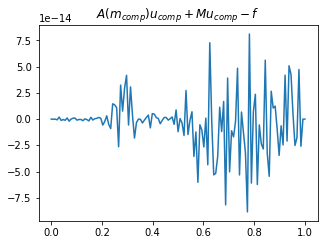

In [358]:
M_array = run.M.array()[1:-1,1:-1]
# assemble the Residual
plt.figure(figsize=(5, 3.6))
LHS = ufl.inner(ufl.exp(m) * ufl.grad(run.u_trial), ufl.grad(run.u_test)) * ufl.dx + run.omega_val * run.f * run.u_trial * run.u_test * ufl.dx 
RHS = run.g_sun * run.u_test * ufl.dx
LHS, RHS = dl.assemble_system(LHS,RHS,run.bc_state)
residual = LHS*u.vector() - RHS
plt.plot(x,residual)
plt.title(r'$A(m_{comp})u_{comp} + Mu_{comp} - f$')
# plt.savefig('./log/img/residual_m_computed.eps', format='eps', dpi=300)
plt.show()


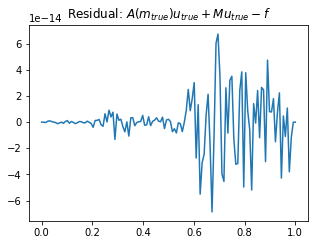

In [28]:
# assemble the Residual
plt.figure(figsize=(5, 3.6))
LHS = ufl.inner(ufl.exp(mtrue) * ufl.grad(run.u_trial), ufl.grad(run.u_test)) * ufl.dx + run.omega_val * run.f * run.u_trial * run.u_test * ufl.dx 
RHS = run.g_sun * run.u_test * ufl.dx
LHS, RHS = dl.assemble_system(LHS,RHS,run.bc_state)
residual = LHS * ud.vector() - RHS
# reisz = np.linalg.solve(M_array, residual[1:-1])
# plt.plot(reisz)
plt.plot(x,residual)
plt.title(r'Residual: $A(m_{true})u_{true} + Mu_{true} - f$')
# plt.savefig('./log/img/residual_m_computed2.eps', format='eps', dpi=300)
plt.show()

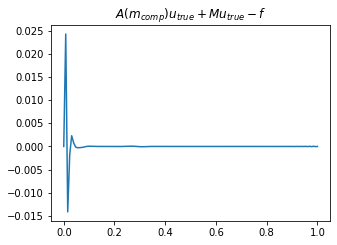

In [29]:
M_array = run.M.array() # Reisz Representative
# assemble the Residual
plt.figure(figsize=(5, 3.6))
LHS = ufl.inner(ufl.exp(m) * ufl.grad(run.u_trial), ufl.grad(run.u_test)) * ufl.dx + run.omega_val * run.f * run.u_trial * run.u_test * ufl.dx 
RHS = run.g_sun * run.u_test * ufl.dx
LHS, RHS = dl.assemble_system(LHS,RHS,run.bc_state)
residual = LHS * ud.vector() - RHS
# residual = M_inv @ residual
# reisz = np.linalg.solve(M_array, residual)
# plt.plot(reisz[1:-2])
plt.plot(x,residual)
plt.title(r'$A(m_{comp})u_{true} + Mu_{true} - f$')
# plt.savefig('./log/img/residual_m_computed_u_true.eps', format='eps', dpi=300)
plt.show()

$u_{test}^T A u$

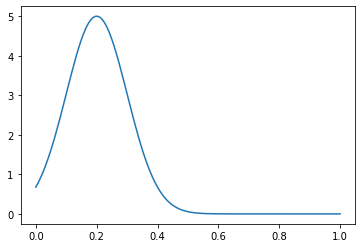

In [30]:
plt.plot(x, run.g_sun.compute_vertex_values())
# plt.plot(x, run.g.compute_vertex_values())

## Check Strong Form

### Check if m_computed and u_computed satisfy strong form

In [42]:
from scipy.ndimage import gaussian_filter
m_FD = m.compute_vertex_values().copy()
m_FD = gaussian_filter(m_FD, 1)
u_FD = u.compute_vertex_values().copy()
u_FD = gaussian_filter(u_FD, 1)
emdu = np.exp(m_FD)*np.gradient(u_FD, x, edge_order=2)
demdu = np.gradient(emdu,x, edge_order=2)
omegadu = omega*f.compute_vertex_values()*u_FD

start_indx, end_index = 5, -5
demdu[start_indx:end_index] = gaussian_filter(demdu[start_indx:end_index], 3)

In [43]:
from utils.general import FD_discretize_equation
A,b = FD_discretize_equation(np.exp(m.compute_vertex_values()), omega*f.compute_vertex_values(), g_sun_true,x, lbc=1, rbc=0)

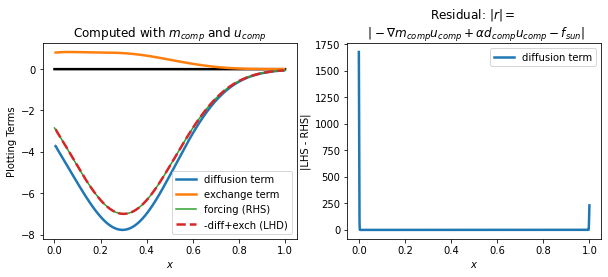

In [44]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6)) 
ax[0].plot(x, np.zeros_like(x), 'k', linewidth=2.5)
ax[0].plot(x[start_indx:end_index], -demdu[start_indx:end_index], label='diffusion term', linewidth=2.5)
ax[0].plot(x[start_indx:end_index], omegadu[start_indx:end_index], label='exchange term', linewidth=2.5)
ax[0].plot(x,run.g_sun.compute_vertex_values(), label='forcing (RHS)')
# ax[0].plot(x, b, label='computed RHS', linewidth=2.5)
ax[0].plot(x[start_indx:end_index], (-demdu + omegadu)[start_indx:end_index], '--', label='-diff+exch (LHD)', linewidth=2.5)
# ax[0].plot(x, A @ u.compute_vertex_values(), label='computed LHS', linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Plotting Terms')
ax[0].set_title(r'Computed with $m_{comp}$ and $u_{comp}$')
ax[0].legend()
LHS_computed = -demdu + omegadu
residual_strong = abs(LHS_computed - run.g_sun.compute_vertex_values())
ax[1].plot(x, residual_strong, label='diffusion term', linewidth=2.5)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel('|LHS - RHS|')
ax[1].set_title(f'Residual: $|r|=$ \n '+r'$|-\nabla m_{comp}u_{comp} + \alpha d_{comp} u_{comp} - f_{sun}|$')
ax[1].legend()

# plt.savefig('./log/img/residual_computed.eps', format='eps', dpi=300)

In [34]:
emdu = np.exp(mtrue_array)*np.gradient(ud_array, x, edge_order=2)
demdu = np.gradient(emdu,x, edge_order=2)
omegadu = omega*f.compute_vertex_values()*ud_array

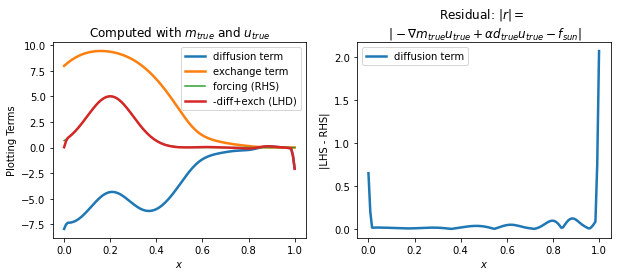

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6)) 
ax[0].plot(x, -demdu, label='diffusion term', linewidth=2.5)
ax[0].plot(x, omegadu, label='exchange term', linewidth=2.5)
ax[0].plot(x,run.g_sun.compute_vertex_values(), label='forcing (RHS)')
ax[0].plot(x, -demdu + omegadu, label='-diff+exch (LHD)', linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Plotting Terms')
ax[0].set_title(r'Computed with $m_{true}$ and $u_{true}$')
ax[0].legend()

LHS_true = -demdu + omegadu
residual_strong = abs(LHS_true - run.g_sun.compute_vertex_values())
ax[1].plot(x, residual_strong, label='diffusion term', linewidth=2.5)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel('|LHS - RHS|')
ax[1].set_title(f'Residual: $|r|=$ \n '+r'$|-\nabla m_{true}u_{true} + \alpha d_{true} u_{true} - f_{sun}|$')
ax[1].legend()

# plt.savefig('./log/img/residual_true.eps', format='eps', dpi=300)
# plt.savefig('./log/img/residual_true.png', format='png', dpi=300)

plt.show()

## Check Coecivity Numerically

In [36]:
bilinear = dl.assemble(ufl.exp(m) * ufl.inner(ufl.grad(u), ufl.grad(u)) * ufl.dx + run.f* ufl.inner(u, u)* run.omega_val * ufl.dx)
L2_u = dl.assemble(ufl.inner(u, u)* ufl.dx)
print(bilinear/L2_u)

26.932379009439085


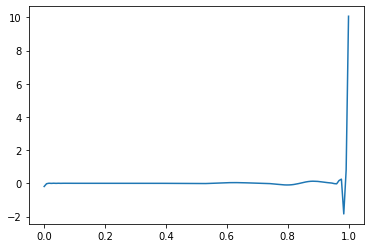

In [37]:
error_LHS = (LHS_computed-LHS_true)
plt.plot(x,error_LHS)

## Quick sensitivity Unit Testing

In [46]:
%load_ext autoreload
%autoreload 2
from utils.general import sensitivity_array


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


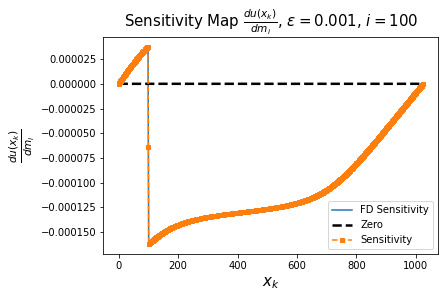

In [50]:
%matplotlib inline

# get array for testing
m_test_array = mtrue_array.copy()
m_test = dl.Function(run.Vm)
m_test.vector().set_local(m_test_array[::-1])

u_test, A_utest,_ = run.fwd_solve(m_test)
sensitivity1, _, _ = sensitivity_array(mtrue_array, u_test.compute_vertex_values(), f.compute_vertex_values(), omega_val=omega)

# get change in m
idx = 100
dm = 0.001
m_plus_dm = dl.Function(run.Vm)
m_plus_dm_array = m_test_array.copy()
m_plus_dm_array[idx] += dm
m_plus_dm.vector().set_local(m_plus_dm_array[::-1])
u_test_change,_,_ = run.fwd_solve(m_plus_dm)

# FD du/dm_i
FD_sen = (u_test_change.compute_vertex_values(run.mesh) - u_test.compute_vertex_values(run.mesh))/dm

plt.plot(FD_sen, label='FD Sensitivity')
plt.plot(np.zeros_like(x), 'k--', label='Zero', linewidth=2.5)
plt.plot(sensitivity1[:,idx], 's--', label='Sensitivity', markersize=4)
plt.xlabel(r'$x_k$', fontsize=15)
plt.legend()
plt.ylabel(r'$\frac{du(x_k)}{dm_i}$', fontsize=15)
plt.title(r'Sensitivity Map $\frac{du(x_k)}{dm_i}$, '+ f'$\epsilon = {dm}$, '+f'$i = {idx}$' , fontsize=15)
# plt.savefig('./log/img/sensitivity.png',format='png',bbox_inches='tight',dpi=300)
# plt.savefig('./log/img/sensitivity_check.eps',format='eps',bbox_inches='tight',dpi=300)
# plt.savefig('./log/img/sensitivity_FD.png',format='png',bbox_inches='tight',dpi=300)
plt.show()

In [55]:
np.linspace(1.0, 0.0, 11)

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

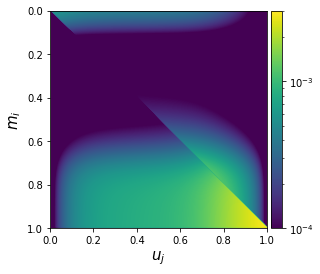

In [51]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# sensitivity1[:,idx]= np.nan
imshow_ticks = [0, 0.2, 0.4, 0.6,0.8, 1.0]

fig, ax = plt.subplots()
im = ax.imshow((abs(sensitivity1)).T, norm=LogNorm(vmin=0.0001),extent=(x[0],x[-1],x[-1],x[0]))
ax.set_ylabel(r'$m_i$', fontsize=15)
ax.set_xlabel(r'$u_j$', fontsize=15,rotation=0)
ax.set_yticks(imshow_ticks)
ax.set_xticks(imshow_ticks)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [102]:
import matplotlib as mpl
colors = mpl.cm.get_cmap('Reds')
# list(colormaps)

In [109]:
np.linspace(0, 6,93)

array([0.        , 0.06521739, 0.13043478, 0.19565217, 0.26086957,
       0.32608696, 0.39130435, 0.45652174, 0.52173913, 0.58695652,
       0.65217391, 0.7173913 , 0.7826087 , 0.84782609, 0.91304348,
       0.97826087, 1.04347826, 1.10869565, 1.17391304, 1.23913043,
       1.30434783, 1.36956522, 1.43478261, 1.5       , 1.56521739,
       1.63043478, 1.69565217, 1.76086957, 1.82608696, 1.89130435,
       1.95652174, 2.02173913, 2.08695652, 2.15217391, 2.2173913 ,
       2.2826087 , 2.34782609, 2.41304348, 2.47826087, 2.54347826,
       2.60869565, 2.67391304, 2.73913043, 2.80434783, 2.86956522,
       2.93478261, 3.        , 3.06521739, 3.13043478, 3.19565217,
       3.26086957, 3.32608696, 3.39130435, 3.45652174, 3.52173913,
       3.58695652, 3.65217391, 3.7173913 , 3.7826087 , 3.84782609,
       3.91304348, 3.97826087, 4.04347826, 4.10869565, 4.17391304,
       4.23913043, 4.30434783, 4.36956522, 4.43478261, 4.5       ,
       4.56521739, 4.63043478, 4.69565217, 4.76086957, 4.82608

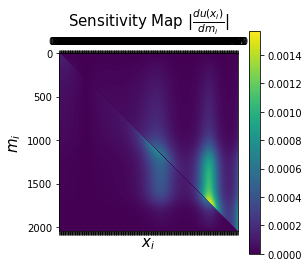

In [ ]:
# mpl.rcParams['figure.dpi'] = 100
%matplotlib inline
from matplotlib.colors import LogNorm
imshow_ticks = [0, 0.2, 0.4, 0.6,0.8, 1.0]
# plt.matshow((abs(sensitivity1)), norm=LogNorm(vmin=0.0001))
plt.matshow((abs(sensitivity1)))
# plt.imshow((abs(sensitivity1)))
ticks_array = np.arange(0, sensitivity1.shape[0], step=8)
# ticks_step = (ticks_array[1] - ticks_array[0])/128
ticks_label = np.linspace(0,1, len(ticks_array))
ticks_label_list = [f'{i:1.2f}' for i in ticks_label]
plt.xticks(ticks_array, ticks_label_list)
plt.xlabel(r'$x_i$', fontsize=15)
plt.ylabel(r'$m_i$', fontsize=15)
plt.title(r'Sensitivity Map $|\frac{du(x_i)}{dm_i}|$', fontsize=15)
plt.colorbar()
# plt.savefig('log/img/sensitivity_well_behaved.png',format='png',bbox_inches='tight',dpi=300)
# plt.savefig('log/img/sensitivity_shift_solar.eps',format='eps',bbox_inches='tight',dpi=300)

Inf norm of misfit: 0.3799878081077


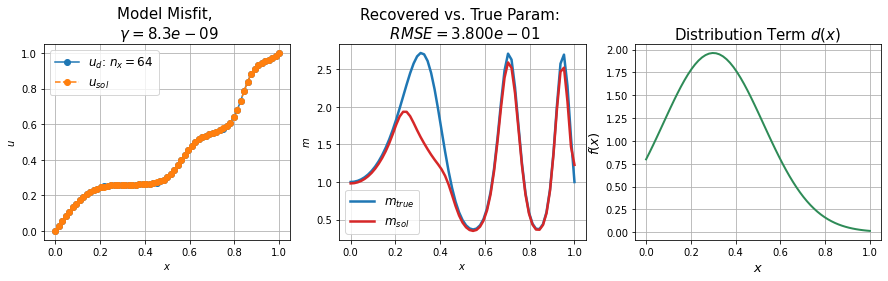

In [ ]:
from utils.general import rmse

error_l2_norm = rmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(x,ud_array, 'o-', label=f'$u_d$: $n_x = {nx}$')
ax[0].plot(x,u.compute_vertex_values(), 'o--', label=r'$u_{sol}$')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(f'Model Misfit, \n $\gamma = {run.gamma:1.1e}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

ax[1].plot(x,np.exp(mtrue_array), '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', color='tab:red', linewidth=2.5)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(f'Recovered vs. True Param: \n $RMSE={error_l2_norm:.3e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

# a1[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')1
ax[2].plot(x, f_array, 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$f(x)$', fontsize=13)
ax[2].set_title(f'Distribution Term $d(x)$', fontsize=15)
# ax[2].legend(prop={'size':12})
# plt.savefig(f'log/img/dist_shift_result3.eps', bbox_inches='tight', format='eps', dpi=300)

print(f'Inf norm of misfit: {error_l2_norm}')

In [ ]:
from utils.general import eig_residual_test

res_norm = eig_residual_test(x, u.compute_vertex_values(), m.compute_vertex_values(), f_array, run.omega)
print(f'Residual Norm: {res_norm}')

Residual Norm: 46.03211352780813


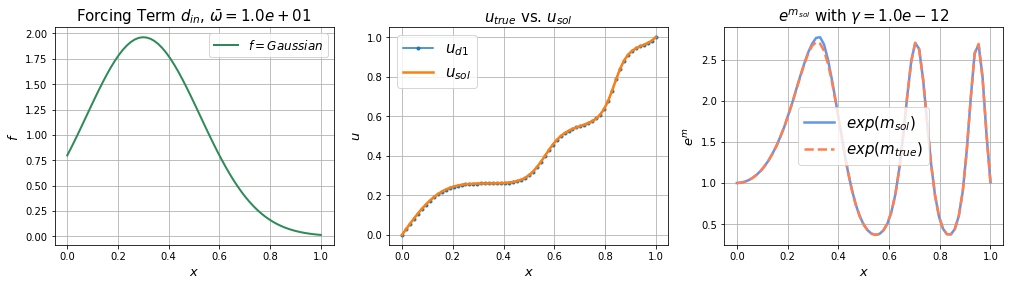

In [ ]:
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
plt.show()

Text(0, 0.5, 'MSE')

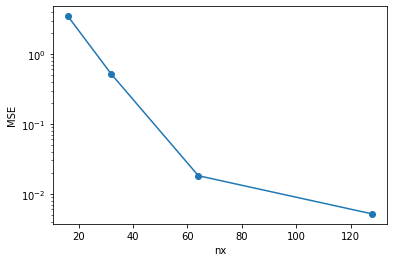

In [ ]:
MSEs = [3.466, 5.138e-1, 1.813e-2, 5.152e-3]
nx = [16, 32, 64, 128]
plt.semilogy(nx, MSEs, 'o-')
plt.xlabel('nx')
plt.ylabel('MSE')

## Linear FEM fwd Solve Test

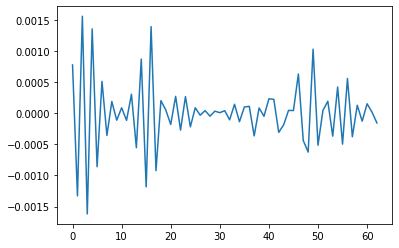

In [ ]:
# set up all the elements
mtrue_el = dl.Function(run.Vm)
mtrue_el.vector().set_local(mtrue_array[::-1])
msol_el = dl.Function(run.Vm)
msol_el.assign(m)
utrue_el = dl.Function(run.Vu)
utrue_el.vector().set_local(ud_array[::-1])
usol_el = dl.Function(run.Vu)
usol_el.assign(u)
distribution_el = dl.Function(run.Vu)
distribution_el.vector().set_local(f_array[::-1])
omega_el = dl.Constant(omega)

# assemble the Residual
residual_sym = ufl.inner(ufl.exp(mtrue_el) * ufl.grad(usol_el), ufl.grad(run.u_test)) * ufl.dx + omega_el * distribution_el * usol_el * run.u_test * ufl.dx - run.g_sun * run.u_test * ufl.dx
residual = dl.assemble(residual_sym)
plt.plot(residual[1:-1])
plt.show()

In [ ]:
mesh = dl.IntervalMesh(64, 0, 1)
Vm = Vu = dl.FunctionSpace(mesh, 'Lagrange', 1)
u_trial, p_trial, m_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vu), dl.TrialFunction(Vu)
u_test, p_test, m_test = dl.TestFunction(Vu), dl.TestFunction(Vu), dl.TestFunction(Vu)
omega_val = dl.Constant(10)
g_sun = dl.Function(Vu)
g_sun.vector().set_local(g_sun_true[::-1])

m = dl.interpolate(mtrue_el, Vm)
f = dl.interpolate(distribution_el, Vu)

a_state = ufl.inner(ufl.exp(m) * ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx + f * omega_val * u_trial * u_test * ufl.dx
L_state = g_sun * u_test * ufl.dx

from utils.general import DboundaryL, DboundaryR
bc_state = [dl.DirichletBC(Vu, u0L, DboundaryL), dl.DirichletBC(Vu, u0R, DboundaryR)]

A, b = dl.assemble_system(a_state, L_state, bc_state)
u = dl.Function(Vu)
dl.solve(A, u.vector(), b)

1

In [ ]:
a_res = ufl.inner(ufl.exp(m) * ufl.grad(u), ufl.grad(u_test)) * ufl.dx + f * omega_val * u * u_test * ufl.dx
L_res = g_sun * u_test * ufl.dx
A_res, b_res = dl.assemble(a_res), dl.assemble(L_res)

In [ ]:
(A_res - b_res).get_local()

array([ 1.43663198e+00, -3.76647283e-15, -2.30534708e-14, -3.00561771e-14,
        2.47385711e-14,  1.71199296e-14, -3.60229825e-15, -3.30728960e-15,
        9.99054791e-15, -1.54844437e-14,  4.60539947e-15, -2.26432366e-15,
       -2.57750127e-15, -3.65327590e-15,  1.64582425e-14, -1.12569953e-14,
       -3.07176406e-14,  3.15170757e-14,  5.28138585e-15, -3.54204547e-14,
       -4.20935397e-14,  2.47572721e-14,  1.30348799e-15, -1.05488467e-15,
        6.02241103e-15,  6.55762066e-15,  6.28810155e-16,  1.05257057e-15,
       -1.11672824e-17, -1.85366045e-15, -1.01047642e-16, -1.28152697e-15,
        4.16854051e-15, -3.86843335e-15,  2.83280344e-15,  1.73472348e-16,
        1.00267017e-14,  7.60502772e-15,  6.57807142e-15,  1.28022593e-14,
       -2.24126273e-15, -2.06293316e-14, -5.35682609e-15,  3.42781359e-15,
        6.59194921e-15, -2.17048601e-14,  2.73114864e-14,  1.33781874e-14,
       -2.39253062e-14,  1.38222767e-14, -1.55431223e-15,  1.44328993e-15,
       -8.49320614e-15,  

## Quick FEM fwd solve Test

u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
u0L: 1.0, u0R: 0.0
2.4942121766390097


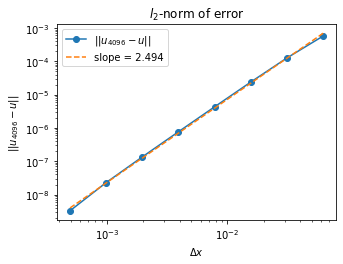

1.9958994057119734


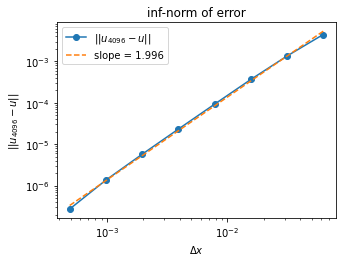

In [ ]:
from helm_eq import single_data_run

import dolfin as dl 
import ufl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
nx_list = [4096] +[2**j for j in range(4,12)]
error_l2_list = []
error_maxnorm_list = []
dx_list = []
for i, nx in enumerate(nx_list):
    # define parameters
    a,b = 0,1   
    bc_type = 'DBC'
    omega = 10
    oce_val = 0.0
    gamma =1.0e-11
    x = np.linspace(0,1,nx+1)
    # initialize FEM solver
    run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
    run.misfit_reg_setup(gamma)
    # define state and adj eq.
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
    run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

    # The true and inverted parameter
    mtrue_expression_str = 'std::sin(pow(x[0],2)*5*pi)'
    # mtrue_expression_str = 'std::log(1)'
    mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
    mtrue =  dl.interpolate(mtrue_expression,run.Vm)
    mtrue_array = mtrue.compute_vertex_values()
    # mtrue.vector().set_local(mtrue_array)
    run.mtrue_setup(mtrue)

    # Distribution term added this I called f in code but it's really d(x)
    from utils.general import normalize_function
    c_1 = 10
    peak_loc = 0.3
    gauss_var = 1/10
    f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
    # f_str = '1'
    f = normalize_function(f_str, run.Vm, ufl.dx)
    f_array = f.compute_vertex_values()
    run.f_setup(f)

    # check for consistency with the way g(x) solar term is saved
    c_1 = 5
    peak_loc = 0.2
    gauss_var = 1/50
    g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
    # g_str = 'std::sin(x[0]*2*pi)'
    g = dl.Expression(g_str, degree=5)
    g = dl.interpolate(g,run.Vm)

    run.extra_f_setup(g_sun=g)

    u0L = 1.0
    u0R = 0.0
    print(f'u0L: {u0L}, u0R: {u0R}')
    run.BC_setup(u0L, u0R)

    u,A,_ = run.fwd_solve(mtrue)
    u_array = u.compute_vertex_values()
    # assign u that I set up for adjustment within the domain
    # plt.plot(x, u_true, label='u_true')
    if i == 0 and nx == 4096:
        u4096 = u.copy()
    else:
        # u_analytic = np.sin(x*2*np.pi)/(4*np.pi**2 + 10)
        # u_compare = u_analytic
        u_compare = dl.interpolate(u4096,run.Vu).compute_vertex_values()
        error_l2 = np.linalg.norm(u_compare-u_array)/len(x)
        error_maxnorm = np.linalg.norm(u_compare-u_array,np.infty)
        error_l2_list.append(error_l2)
        error_maxnorm_list.append(error_maxnorm)
        dx_list.append(x[1]-x[0])

nx_list.pop(0)
plt.figure(figsize=(5,3.6))
dx_array = np.array(dx_list)
slope, intercept =  np.polyfit(np.log(np.array(dx_array)), np.log(np.array(error_l2_list)), 1)
print(slope)
plt.loglog(dx_list,error_l2_list, 'o-', label=r'$||u_{4096} - u||$')
plt.loglog(dx_array, np.exp(slope * np.log(dx_array) + intercept),'--', label = f'slope = {slope:1.3f}')
plt.legend()
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$||u_{4096} - u||$')
plt.title(r'$l_2$-norm of error')
# plt.savefig('./log/img/l2_u_error.png', dpi=300)
plt.show()

plt.figure(figsize=(5,3.6))
dx_array = np.array(dx_list)
slope, intercept =  np.polyfit(np.log(np.array(dx_array)), np.log(np.array(error_maxnorm_list)), 1)
print(slope)
plt.loglog(dx_list,error_maxnorm_list, 'o-', label=r'$||u_{4096} - u||$')
plt.loglog(dx_array, np.exp(slope * np.log(dx_array) + intercept),'--', label = f'slope = {slope:1.3f}')
plt.legend()
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$||u_{4096} - u||$')
plt.title(r'inf-norm of error')
# plt.savefig('./log/img/maxnorm_u_error.png', dpi=300)
plt.show()

## Lax-Milgram Condition Check

Theorem stated that we need our bilinear mapping to be continuous, which is defined by $$|B[u,v]| \leq \alpha ||u||\,||v||,$$ and coercive, which is defined by $$\beta ||u||^2 \leq B[u,u].$$

From my PDE, I have coerciveness bilinear mapping defined as $$B[u,u] = \int_\Omega e^m \nabla u\cdot \nabla u + d(x) u^2 \, dx - \int_{\partial \Omega}ue^m\nabla u \cdot \textbf{n}\,ds$$

In [ ]:

boundaries = dl.MeshFunction("size_t", run.mesh, run.mesh.topology().dim()-1)
# boundaries = dl.FacetFunction()
from utils.general import NboundaryL, NboundaryR
left = NboundaryL()
right = NboundaryR()
# mark left and right boundary
left.mark(boundaries, 0)
right.mark(boundaries, 1)
# define boundary
ds = dl.Measure('ds')(subdomain_data=boundaries)

# dl.assemble(ufl.exp(mtrue) * ufl.inner(ufl.grad(run.ud),ufl.grad(run.ud))*ufl.dx + run.f * run.omega_val * run.ud * run.ud * ufl.dx)

In [ ]:
ufl.FacetNormal(run.mesh)

FacetNormal(Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 0))

The following is printin the boundary term of $-ue^m\nabla u |_L^R$

In [ ]:
du = np.gradient(ud_array, run.mesh.hmax(), edge_order=2)
print('Left boundary term:', run.ud.compute_vertex_values()[0] * du[0] * np.exp(mtrue.compute_vertex_values()[0]))
print('Right boundary term:', run.ud.compute_vertex_values()[-1] * du[-1] * np.exp(mtrue.compute_vertex_values()[-1]))

Left boundary term: -4.074066959272113
Right boundary term: -0.0


In [ ]:
normal = ufl.FacetNormal(run.mesh)
L_boundary_term = dl.assemble(run.ud * ufl.exp(mtrue) * ufl.inner(ufl.grad(run.ud),-normal) * ds(0)) # need negative on normal because normal is pointing away from domain although this is 1D
R_boundary_term = dl.assemble(run.ud * ufl.exp(mtrue) * ufl.inner(ufl.grad(run.ud),normal) * ds(1))
print(L_boundary_term, R_boundary_term)

-3.9953807481993664 0.0


In [ ]:
dl.assemble(ufl.exp(m) * ufl.inner(ufl.grad(u),ufl.grad(u))*ufl.dx \
            + run.f * run.omega_val * u * u * ufl.dx \
            + run.ud * ufl.exp(m) * ufl.inner(ufl.grad(u),-normal) * ds(0) \
            - run.ud * ufl.exp(m) * ufl.inner(ufl.grad(u),normal) * ds(1))

Calling FFC just-in-time (JIT) compiler, this may take some time.


0.08689582091437398

## Adjoint Check of Forward

In [ ]:
import numpy as np


def is_self_adjoint(A):
  """Checks if a square matrix is self-adjoint (Hermitian).
  """
  if not np.allclose(A, A.conj().T):
    return False
  return True

_, A, b = run.fwd_solve(mtrue)
print(is_self_adjoint(A.array()))

True


# Analytical $u$ solution

In this setup, we are looking at the equation of $$-D\Delta u + 10 d(x)u  = f(x)$$ where $f(x) = \sin(2\pi x)$ and the boundary condition is $u(0)=u(1)=0$. Here we are assuming $D(x)=1$ and $d(x)=1$. This means our analytical solution should be $$u = \frac{\sin(2\pi x)}{2\pi^2+10}.$$ I will do all the test to see if this is the case

In [ ]:
from helm_eq import single_data_run

import dolfin as dl 
import ufl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

nx = 64
a,b = 0,1
bc_type = 'DBC'
omega = 10
oce_val = 0.0
gamma =1.0e-11
x = np.linspace(0,1,nx+1)

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
## === poisson ===
# a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx'
# L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx'
# a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx'
# L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

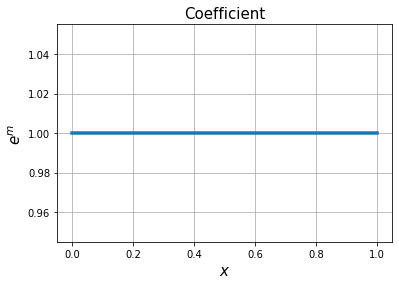

In [ ]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
mtrue_expression_str = 'std::sin(pow(x[0],2)*5*pi)'
mtrue_expression_str = 'std::log(1)'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue =  dl.interpolate(mtrue_expression,run.Vm)
mtrue_array = mtrue.compute_vertex_values()
# mtrue.vector().set_local(mtrue_array)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(x,np.exp(mtrue.compute_vertex_values()), '-',linewidth=3.5)
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Distribution Forcing

Text(0.5, 1.0, 'Distribution $d(x)$')

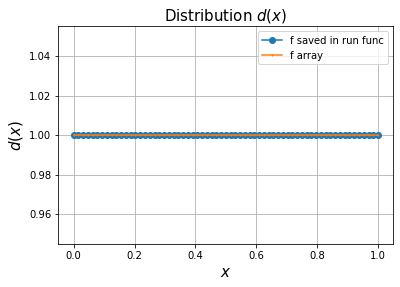

In [ ]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f_str = '1'
f = normalize_function(f_str, run.Vm, ufl.dx)
f_array = f.compute_vertex_values()
run.f_setup(f)

plt.plot(x,run.f.compute_vertex_values(), 'o-', label = 'f saved in run func')
plt.plot(x,f_array, 'o-', markersize=1, label='f array')
plt.legend()
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$d(x)$', fontsize=15)
plt.title('Distribution $d(x)$',fontsize=15)

## Solar 

Text(0.5, 1.0, 'Solar Term')

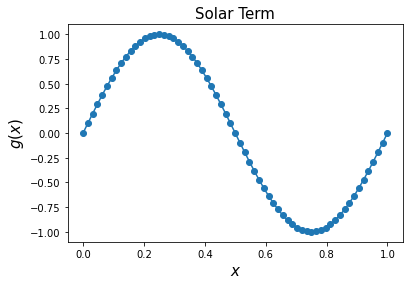

In [ ]:
c_1 = 5
peak_loc = 0.2
gauss_var = 1/50
g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
# g_str = 'std::exp(-5 * x[0]-1)'
g_str = 'std::sin(x[0]*2*pi)'
g = dl.Expression(g_str, degree=5)
g = dl.interpolate(g,run.Vm)
g_sun_true = g.compute_vertex_values()
# g.vector().set_local(g_sun_true)


run.extra_f_setup(g_sun=g)
plt.plot(x,run.g_sun.compute_vertex_values(), 'o-')
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$g(x)$', fontsize=15)
plt.title('Solar Term',fontsize=15)

## Boundary Condition

In [ ]:
# u0L = 0.0#cos(0.0)*3*pi
# u0R = 1.0 #cos(3*pi)*3*pi
u0L = 0.0
u0R = 0.0
# u0L = u_true[0]
# u0R = u_true[-1]
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 0.0, u0R: 0.0


## Setup Data

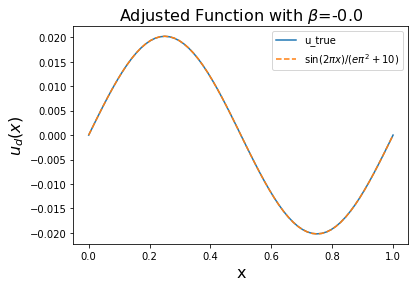

In [ ]:
u,A,_ = run.fwd_solve(mtrue)
u_true = u.compute_vertex_values()
# assign u that I set up for adjustment within the domain
plt.plot(x, u_true, label='u_true')

beta = -0.000
# adj_func = beta*sigmoid_dx2(x_test,k=5)
# u_true += adj_func
u_analytic = np.sin(x*2*np.pi)/(4*np.pi**2 + 10)
plt.plot(x, u_analytic, '--', label=r'$\sin(2\pi x)/(e\pi^2 +10)$')
plt.legend()
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$u_d(x)$', fontsize=16)
plt.title(f'Adjusted Function with '+r'$\beta$'+f'={beta}', fontsize=16)
plt.show()

np.random.seed(0)
noise_level = 0.00
MAX = u.vector().norm("linf")
noise = dl.Vector()
A.init_vector(noise, 1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(u.vector().get_local())) )
run.bc_adj.apply(noise)
u.vector().axpy(1.0, noise)

# max_norm = np.max(abs(u_true))
# noise = noise_level * max_norm * np.random.normal(0,1,u_true.shape)
# noise[0] = noise [-1] = 0
# ud_array = u_true + noise

# plt.plot(x, u.compute_vertex_values())
ud = u.copy()
ud_array = ud.compute_vertex_values()
# ud = dl.Function(run.Vu)
# ud.vector().set_local(ud_array[::-1])
# plt.plot(x, ud.compute_vertex_values())
# plt.plot(x, u_true)
run.data_setup(ud = ud, normalize=False)
# run.data_setup(ud_array=ud_array)

# plt.plot(x, run.ud.compute_vertex_values())

In [ ]:
dl.assemble(run.ud * dl.ds)

0.0

## Initial Guess

0.0
0.0


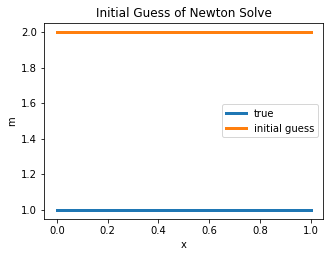

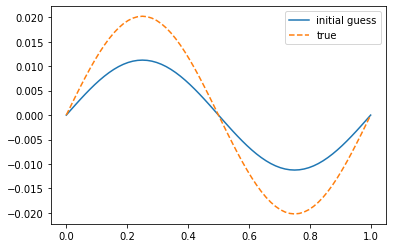

In [ ]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# np.random.seed(2)
# perturb_level = 0.1
# MAX = m.vector().norm("linf")
# init_m_perturb = dl.Vector()
# A.init_vector(init_m_perturb, 1)
# noise.set_local( perturb_level * MAX * np.random.normal(0, 1, len(m.vector().get_local())) )
# run.bc_adj.apply(init_m_perturb)
# m.vector().axpy(1.0, noise)
# m_init_array = mtrue.compute_vertex_values()
# idx = 50
# m_init_array[idx] *= 5
# m.vector().set_local(m_init_array[::-1])
# m = mtrue

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])


plt.figure(figsize=(5,3.6))
plt.plot(x, np.exp(mtrue.compute_vertex_values()), label='true', linewidth=3)
plt.plot(x, np.exp(m.compute_vertex_values()), '-',label='initial guess',linewidth=3)
plt.legend()
plt.xlabel('x')
plt.ylabel('m')
plt.title('Initial Guess of Newton Solve')
# plt.savefig('log/img/initial_guess.eps', bbox_inches='tight', format='eps', dpi=300)
plt.show()

plt.plot(x, u.compute_vertex_values(), label='initial guess')
plt.plot(x, ud.compute_vertex_values(), '--', label='true')
plt.legend()

## Optmization Step

In [ ]:
tol = 1e-12
c = 1e-4
maxiter=50
m, u = run.opt_loop(m, tol, c, maxiter, plot_opt_step=False, save_opt_log=False)

Nit   CGit   cost          misfit        reg         rel_gradnorm    (G*D)/(l)       ||grad||       alpha      tolcg
 1     1   4.74511e-06   9.48949e-06   7.35090e-10   1.00000e+00   6.28997e-03   5.46224e-05   1.00e+00   5.000e-01
 2     1   2.73312e-07   5.46208e-07   4.15513e-10   9.69916e-01   3.00355e-03   5.29791e-05   1.00e+00   5.000e-01
 3     4   4.31105e-08   8.55936e-08   6.27435e-10   7.28786e-02   7.11377e-04   3.98081e-06   1.00e+00   7.288e-02
 4     4   7.68636e-09   1.48716e-08   5.01147e-10   5.25777e-02   2.69117e-04   2.87192e-06   1.00e+00   5.258e-02
 5    24   6.89697e-10   1.30890e-09   7.04921e-11   1.10716e-02   1.23581e-04   6.04759e-07   1.00e+00   1.107e-02
 6    19   8.74388e-12   1.57322e-11   1.75552e-12   4.54662e-03   3.60786e-05   2.48347e-07   1.00e+00   4.547e-03
 7    40   9.00930e-15   1.48523e-14   3.16629e-15   1.08962e-04   4.14045e-06   5.95178e-09   1.00e+00   1.090e-04
 8    28   2.30818e-17   1.72239e-17   2.89398e-17   4.12629e-06   1.34

## Results

Inf norm of misfit: 1.310530484736232e-05


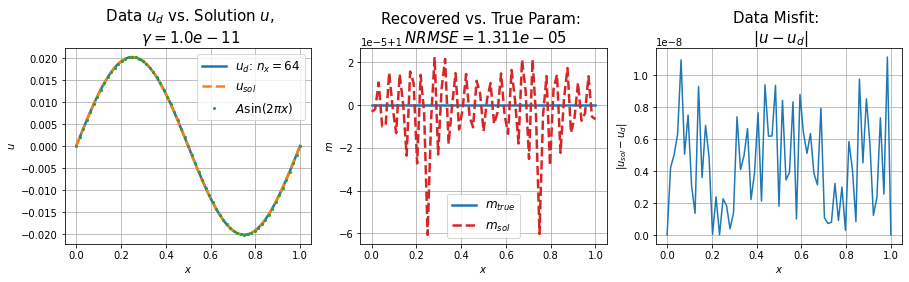

In [ ]:
from utils.general import rmse,nmse
%matplotlib inline
# error, error_label = rmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array)), 'RMSE'
error, error_label = np.sqrt(nmse(np.exp(m.compute_vertex_values()),  np.exp(mtrue_array))), 'NRMSE'
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(x,ud.compute_vertex_values(), '-', label=f'$u_d$: $n_x = {nx}$', markersize=2, linewidth=2.5)
ax[0].plot(x,u.compute_vertex_values(), '--', label=r'$u_{sol}$', markersize=2, linewidth=2.5)
ax[0].plot(x, u_analytic, 'o', label=r'$A\sin(2\pi x)$', markersize=2, linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(f' Data $u_d$ vs. Solution $u$, \n $\gamma = {run.gamma:1.1e}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

ax[1].plot(x,np.exp(mtrue_array), '-', label=r'$m_{true}$', color='tab:blue', linewidth=2.5)
ax[1].plot(x,np.exp(m.compute_vertex_values()), '--', label=r'$m_{sol}$', color='tab:red', linewidth=2.5)
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(f'Recovered vs. True Param: \n ${error_label}={error:.3e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].plot(x, abs(ud.compute_vertex_values() - u.compute_vertex_values()))
# ax[2].plot(x, run.g_sun.compute_vertex_values())
ax[2].set_title(f'Data Misfit: \n $|u - u_d|$', fontsize=15)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$|u_{sol} - u_d|$')
ax[2].grid()

# ax[2].loglog(misfit, reg/gamma, 'o')
# ax[2].plot(misfit[kappa_min_ind], reg[kappa_min_ind]/gamma[kappa_min_ind], 'ro', label = f'gamma = {gamma[kappa_min_ind]:.3e}')
# ax[2].set_xlabel(r'$||u_{sol} - u_d||_2$')
# ax[2].set_ylabel(r'$||\nabla m||_2$')
# ax[2].set_title(r'L-Curve: Opt $\gamma$ Selection', fontsize=15)
# # ax[2].grid()
# ax[2].legend()
# plt.savefig(f'log/img/analytical_solution.eps', bbox_inches='tight', format='eps', dpi=300)

print(f'Inf norm of misfit: {error}')

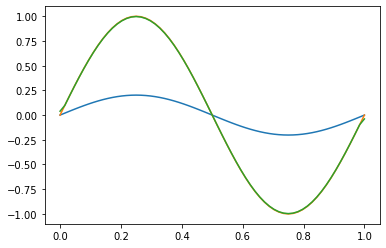

In [ ]:
u_array = u.compute_vertex_values()
du = np.gradient(u_array, x, edge_order=1)
emdu = np.exp(mtrue_array)*du
demdu = np.gradient(emdu, x, edge_order=1)
omegadu = omega*run.f.compute_vertex_values()*u_array


# plt.plot(x,du)
# plt.plot(x,emdu)
# plt.plot(x,demdu)
plt.plot(x,omegadu)
plt.plot(x, run.g_sun.compute_vertex_values())
plt.plot(x, -demdu + omegadu)

## Finite Difference

We are trying to solve $$-\nabla(D(x)\nabla u ) + d(x) u =f(x)$$ which using the product rule becomes $$-D(x)\Delta u - \nabla D(x)\cdot \nabla u + d(x) u = f(x)$$


### Testing np.grad Funct

Text(0, 0.5, 'y')

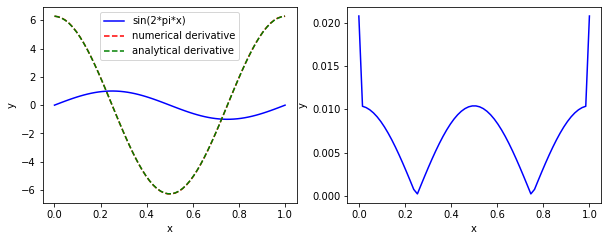

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
nx = 64
x = np.linspace(0, 1, nx)
sinx = np.sin(2*np.pi*x)
numerical_dsinx = np.gradient(sinx, x, edge_order=2)
analytical_dsinx = 2*np.pi*np.cos(2*np.pi*x)
fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6))
ax[0].plot(x, sinx, 'b-', label='sin(2*pi*x)')
ax[0].plot(x, analytical_dsinx, 'r--', label='numerical derivative')
ax[0].plot(x, numerical_dsinx, 'g--', label='analytical derivative')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend()
ax[1].plot(x, abs(analytical_dsinx - numerical_dsinx), 'b-')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

### Testing $m$ that starts oscillating

Text(0.5, 0, 'x')

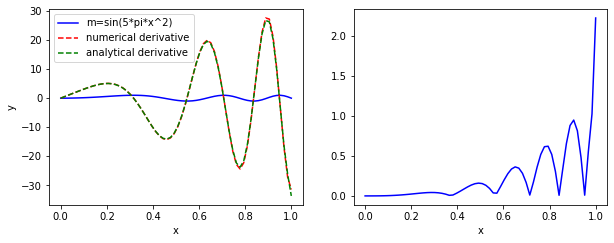

In [ ]:
oscillating_sin = np.sin(5*np.pi*x**2)
analytical_osc_sin = 10*np.pi*np.cos(5*np.pi*x**2) * x
numerical_osc_sin = np.gradient(oscillating_sin, x, edge_order=2)

fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6))
ax[0].plot(x, oscillating_sin, 'b-', label='m=sin(5*pi*x^2)')
ax[0].plot(x, analytical_osc_sin, 'r--', label='numerical derivative')
ax[0].plot(x, numerical_osc_sin, 'g--', label='analytical derivative')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend()
ax[1].plot(x, abs(analytical_osc_sin - numerical_osc_sin), 'b-')
ax[1].set_xlabel('x')

### Testing FD discretization on Problem where I know the analytical solution

In [ ]:
def discretize_equation(D, d, f, x, lbc=0, rbc=0):
    """ 
    Discretizes the equation -d/dx (D(x) d/dx u) + d(x) u = f(x) using finite differences. -D(x) * d²u/dx² - D'(x) * du/dx + d(x) u
    """

    n = len(x)  # Number of points
    dx = x[1] - x[0] 

    # Initialize the A and b for the linear stuff (Au = b)
    A = np.zeros((n, n))
    b = np.zeros(n)

    dD = np.gradient(D, x, edge_order=2)

    # Interior points
    for i in range(1, n - 1):
        A[i, i - 1] = -D[i] / dx**2 + dD[i] / (2*dx)
        A[i, i] = D[i] * 2  / dx**2 + d[i]
        A[i, i + 1] = -D[i] / dx**2 - dD[i] / (2*dx)
        b[i] = f[i]

    # Boundary conditions. adjust based on your specific problem
    A[0, 0] = 1
    b[0] = lbc
    A[n - 1, n - 1] = 1
    b[n - 1] = rbc

    return A, b

In [ ]:
nx = 100
x = np.linspace(0, 1, nx)

D = np.ones(nx)
d = np.ones(nx)*10
f = np.sin(2*np.pi*x)

A, b = discretize_equation(D, d, f, x)

In [ ]:
u = np.linalg.solve(A, b)

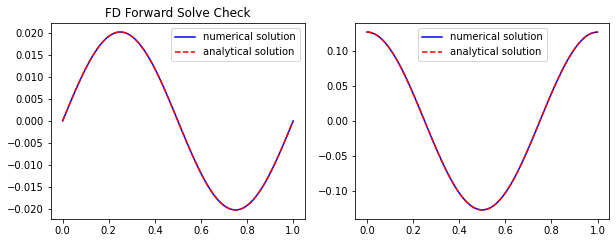

In [ ]:
anallytical_sol = np.sin(2*np.pi*x)/((2*np.pi)**2+10)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6))
ax[0].plot(x, u, 'b-', label='numerical solution')
ax[0].plot(x, anallytical_sol, 'r--', label='analytical solution')
ax[0].legend()
ax[0].set_title('FD Forward Solve Check')

ax[1].plot(x, np.gradient(anallytical_sol, x), 'b-', label='numerical solution')
ax[1].plot(x, np.cos(2*np.pi*x)/((2*np.pi)**2+10)*2*np.pi, 'r--', label='analytical solution')
ax[1].legend()
# ax[1]
# ax[1]

#### Test on no analytical solution

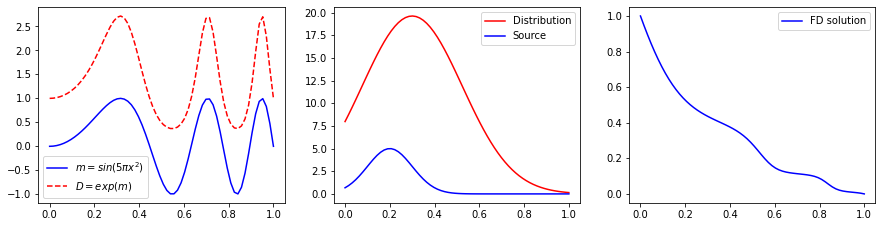

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

nx = 64
x = np.linspace(0, 1, nx)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6))
m = np.sin(5*np.pi*x**2)
D = np.exp(m)
ax[0].plot(x, m, 'b-', label=r'$m=sin(5\pi x^2)$')
ax[0].plot(x,D, 'r--', label=r'$D=exp(m)$')
ax[0].legend()

d = np.exp(-10*(x-0.3)**2) * 10
d_int = np.trapz(d, x)
d /= d_int
d *= 10
f = np.exp(-50*(x-0.2)**2) * 5

ax[1].plot(x, d, 'r-', label=r'Distribution')
ax[1].plot(x, f, 'b-', label=r'Source')
ax[1].legend()

A,b = discretize_equation(D, d, f, x, lbc=1, rbc=0)
u = np.linalg.solve(A, b)
ax[2].plot(x, u, 'b-', label='FD solution')
ax[2].legend()

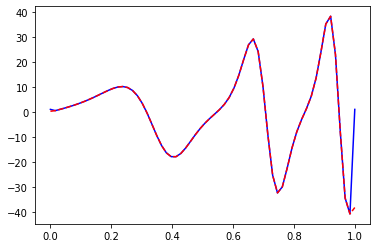

In [ ]:
A_central = np.zeros((nx,nx))
nx_val_of_A = A_central.shape[0]
dx = x[1] - x[0]
for i in range(1, nx_val_of_A-1):
    A_central[i, i+1] = 1/(2*dx)
    A_central[i, i-1] = -1/(2*dx)

A_central[0,0] = A_central[-1,-1] = 1
plt.plot(x, (A_central@D), 'b-')
plt.plot(x, np.gradient(D,dx), 'r--')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


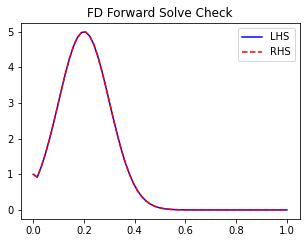

In [ ]:
plt.figure(figsize=(5, 3.6))
plt.plot(x,A@u,'b-', label = 'LHS')
plt.plot(x, b, 'r--', label = 'RHS')
plt.legend()
plt.title('FD Forward Solve Check')
# plt.plot(x, u, 'b-', label='numerical solution')
# plt.plot(x, anallytical_sol, 'r--', label='analytical solution')
# plt.legend()
# plt.title('FD Forward Solve Check')
# plt.plot(x, b, 'r--')
# plt.savefig('./log/img/FD_forward_check.eps', bbox_inches='tight', format='eps')

In [ ]:
res = (A@u-b)[2:-2]
print(np.linalg.norm(res)/nx)

5.10386074461105e-14


In [ ]:
emdu = D*np.gradient(u, x, edge_order=2)
demdu = np.gradient(emdu,x, edge_order=2)
omegadu = d * u

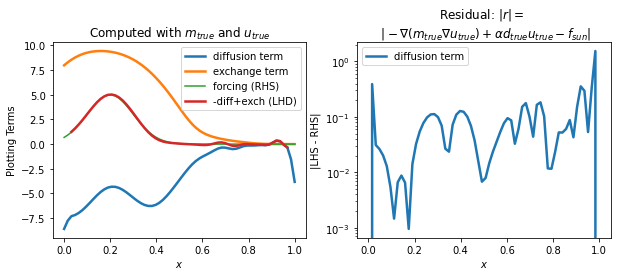

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6)) 
ax[0].plot(x, -demdu, label='diffusion term', linewidth=2.5)
ax[0].plot(x, omegadu, label='exchange term', linewidth=2.5)
ax[0].plot(x,f, label='forcing (RHS)')
ax[0].plot(x[2:-2], (-demdu + omegadu)[2:-2], label='-diff+exch (LHD)', linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Plotting Terms')
ax[0].set_title(r'Computed with $m_{true}$ and $u_{true}$')
ax[0].legend()

LHS_true = -demdu + omegadu
residual_strong = np.zeros(LHS_true.shape)
residual_strong[1:-1] = abs(LHS_true[1:-1] - b[1:-1])
ax[1].semilogy(x, residual_strong, label='diffusion term', linewidth=2.5)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel('|LHS - RHS|')
ax[1].set_title(f'Residual: $|r|=$ \n '+r'$|-\nabla( m_{true}\nabla u_{true}) + \alpha d_{true} u_{true} - f_{sun}|$')
ax[1].legend()
# plt.savefig('./log/img/residual_true.png', format='png', dpi=300)

In [ ]:
du = np.gradient(u, x, edge_order=2)
dDdu = np.gradient(D,x,edge_order=2) * du
Dddu = D * np.gradient(du, x, edge_order=2)
demdu2 = dDdu + Dddu

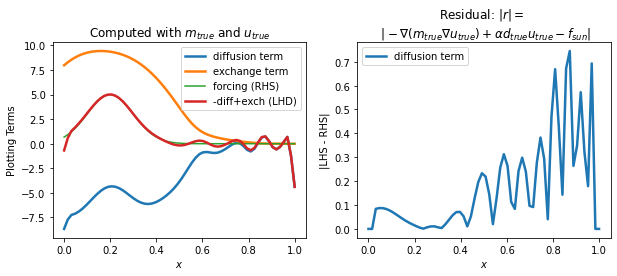

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.6)) 
ax[0].plot(x, -demdu2, label='diffusion term', linewidth=2.5)
ax[0].plot(x, omegadu, label='exchange term', linewidth=2.5)
ax[0].plot(x,f, label='forcing (RHS)')
ax[0].plot(x, -demdu2 + omegadu, label='-diff+exch (LHD)', linewidth=2.5)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Plotting Terms')
ax[0].set_title(r'Computed with $m_{true}$ and $u_{true}$')
ax[0].legend()

LHS_true = -demdu2 + omegadu
residual_strong = np.zeros(LHS_true.shape)
residual_strong[2:-2] = abs(LHS_true[2:-2] - f[2:-2])
ax[1].plot(x, residual_strong, label='diffusion term', linewidth=2.5)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel('|LHS - RHS|')
ax[1].set_title(f'Residual: $|r|=$ \n '+r'$|-\nabla( m_{true}\nabla u_{true}) + \alpha d_{true} u_{true} - f_{sun}|$')
ax[1].legend()

plt.savefig('./log/img/residual_true2.png', format='png', dpi=300)

In [ ]:
np.linalg.norm(residual_strong, ord=np.inf)

0.7449143140527024

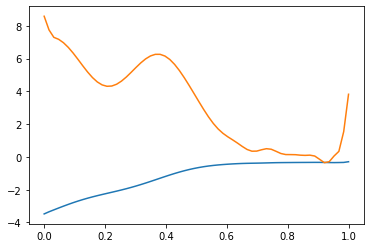

In [ ]:
plt.plot(x,emdu)
plt.plot(x,demdu)